We consider the spring model
\begin{cases} 
  u'' + Cu' + Ku = 0 & t>0\\
  u(0) = 2\\
  u'(0) = -C
\end{cases}
Which has the analytical solution
\begin{align}
u(t) &= 2 e^{\frac{-Ct}{2}} cos\left(\sqrt{K-\frac{C^2}{4}}t\right)
\end{align}

#### Load modules and functions

In [1]:
import os as os
import warnings
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable
import sys as sys
import time as time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sn
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import arviz as az
    import pymc3 as pm
    import theano.tensor as tt
    import theano
from numpy.linalg import inv
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import odeint
from scipy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy import integrate
save_folder = "spring_problem_numerical/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [2]:
def pendulum_analytical_solution(C,K,t):
  # Analytical solution of u(t)
  sol = 2 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)
  return sol
def dudt(C,K,t):
  # Analytical solution of u'(t)
  sol = -C*np.exp(-C*t/2)*np.cos(np.sqrt(-C**2 +4*K)*t/2) -np.exp(-C*t/2)*np.sqrt(-C**2 +4*K) * np.sin(1/2*np.sqrt(-C**2 +4*K)*t)
  return sol
def get_time(time_config):
  # Generate the time steps
  T_max = time_config[0]
  size = time_config[1]

  t = np.linspace(0, T_max, size)
  return t

In [3]:
class SquaredExponential:
    def __init__(self, coords, mkl, lamb, var):
        # Internalise the grid and set number of vertices.
        self.coords = coords # linspace(0,T_max,300)
        self.n_points = self.coords.shape[0] # 300
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb
        self.var = var

        self.cov = self.squared_exponential_kernel(self.coords,self.coords, self.lamb, self.var)
    def squared_exponential_kernel(self, x, y, lengthscale=0.1, var = 1):
      # https://www.cs.toronto.edu/~duvenaud/cookbook/
      return var * np.exp(-np.subtract.outer(x, y)**2/(2*lengthscale**2)) #300x300
    def compute_eigenpairs(self):
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))
        order = np.flip(np.argsort(eigvals))
        self.eigenvalues = eigvals[order]
        self.eigenvectors = eigvecs[:, order]

    def generate(self, parameters):
        self.parameters = np.array(parameters).flatten()

        self.random_field = np.linalg.multi_dot(
            (self.eigenvectors, np.sqrt(np.diag(self.eigenvalues)), self.parameters)
        )
class Matern52:
    def __init__(self, coords, mkl, lamb, var):
        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb
        self.var = var

        self.cov = self.Matern52_kernel(self.coords,self.coords, self.lamb, self.var)
    def Matern52_kernel(self, x, y, lengthscale=0.1, var = 1):
      # https://docs.pymc.io/en/stable/pymc-examples/examples/samplers/MLDA_gravity_surveying.html
      dist = abs(np.subtract.outer(x, y))
      return var * (1+ np.sqrt(5)*dist/lengthscale + 5*dist**2/(3*lengthscale**2))*np.exp(-np.sqrt(5)*dist/lengthscale)
    def compute_eigenpairs(self):
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))
        order = np.flip(np.argsort(eigvals))
        self.eigenvalues = eigvals[order]
        self.eigenvectors = eigvecs[:, order]

    def generate(self, parameters):
        self.parameters = np.array(parameters).flatten()

        self.random_field = np.linalg.multi_dot(
            (self.eigenvectors, np.sqrt(np.diag(self.eigenvalues)), self.parameters)
        )
class RationalQuadraticKernel:
    def __init__(self, coords, mkl, lamb, alpha, var):
        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb
        self.alpha = alpha
        self.var = var

        self.cov = self.get_RationalQuadraticKernel(self.coords,self.coords, self.lamb, self.var, self.alpha )
    def get_RationalQuadraticKernel(self, x, y, lengthscale=0.1, var = 1, alpha = 1.0):
      # https://www.cs.toronto.edu/~duvenaud/cookbook/
      dist = np.subtract.outer(x, y)
      return var * (1 + dist**2/(2*alpha*lengthscale**2))**(-alpha)
    def compute_eigenpairs(self):
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))
        order = np.flip(np.argsort(eigvals))
        self.eigenvalues = eigvals[order]
        self.eigenvectors = eigvecs[:, order]

    def generate(self, parameters):
        self.parameters = np.array(parameters).flatten()

        self.random_field = np.linalg.multi_dot(
            (self.eigenvectors, np.sqrt(np.diag(self.eigenvalues)), self.parameters)
        )
class SquaredExponential_combined:
    def __init__(self, coords, mkl, lamb, p, var):
        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb
        self.p = p
        self.var = var

        self.cov1 = self.squared_exponential_kernel(self.coords,self.coords, self.lamb, self.var)
        self.cov2 = self.get_ExpSineSquaredKernel(self.coords,self.coords, self.lamb, self.p, self.var)
        self.cov = self.cov1*self.cov2
    def squared_exponential_kernel(self, x, y, lengthscale=0.1, var = 1):
      # https://www.cs.toronto.edu/~duvenaud/cookbook/
      return var * np.exp(-np.subtract.outer(x, y)**2/(2*lengthscale**2))
    def get_ExpSineSquaredKernel(self, x, y, lengthscale=0.1, p=20, var = 1):
      # https://www.cs.toronto.edu/~duvenaud/cookbook/
      dist = np.subtract.outer(x, y)
      return var * np.exp(-2*np.sin(np.pi*dist/p)**2/lengthscale**2)
    def compute_eigenpairs(self):
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))
        order = np.flip(np.argsort(eigvals))
        self.eigenvalues = eigvals[order]
        self.eigenvectors = eigvecs[:, order]

    def generate(self, parameters):
        self.parameters = np.array(parameters).flatten()

        self.random_field = np.linalg.multi_dot(
            (self.eigenvectors, np.sqrt(np.diag(self.eigenvalues)), self.parameters)
        )
class ExpSineSquaredKernel:
    def __init__(self, coords, mkl, lamb, p, var):
        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb
        self.var = var
        self.p = p

        self.cov = self.get_ExpSineSquaredKernel(self.coords,self.coords, self.lamb, self.p, self.var)
    def get_ExpSineSquaredKernel(self, x, y, lengthscale=0.1, p = 20, var = 1):
      # https://www.cs.toronto.edu/~duvenaud/cookbook/
      dist = np.subtract.outer(x, y)
      return var * np.exp(-2*np.sin(np.pi*dist/p)**2/lengthscale**2)
    def compute_eigenpairs(self):
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))
        order = np.flip(np.argsort(eigvals))
        self.eigenvalues = eigvals[order]
        self.eigenvectors = eigvecs[:, order]

    def generate(self, parameters):
        self.parameters = np.array(parameters).flatten()

        self.random_field = np.linalg.multi_dot(
            (self.eigenvectors, np.sqrt(np.diag(self.eigenvalues)), self.parameters)
        )
def get_all_kernel_names():
  return ["SquaredExponential", "Matern52", "RationalQuadraticKernel", "ExpSineSquaredKernel", "SquaredExponential_combined"]

In [4]:
def get_prediction(random_process, parameters):
  random_process.generate(parameters)
  mean = 0.0
  stdev = 1.0
  output = mean + stdev * random_process.random_field
  return output

def my_loglik(theta, data, random_process, T_max, sigma = 1.0):
  """
  This returns the log-likelihood of my_model given theta,
  datapoints, the observed data and sigma. It uses the
  model_wrapper function to do a model solve.
  """
  theta = np.array(theta).flatten()

  # Solve system
  output = get_prediction(random_process, theta)

  # Get likelihood
  likelihood = -(0.5 / sigma ** 2) * np.sum((output - data) ** 2) # negative log likelihood for gaussian
  return likelihood
# In order to use the likelihood in PyMc we need a Theano Ops function
class LogLike(tt.Op):
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, random_process, T_max, sigma):
        # add inputs as class attributes
        self.likelihood = loglike
        self.random_process = random_process
        self.T_max = T_max
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # call the log-likelihood function
        logl = self.likelihood(inputs, self.data, self.random_process, self.T_max, self.sigma)
        outputs[0][0] = np.array(logl)  # output the log-likelihood

## Find best number of parameters

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "n_parameters_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 200
t = np.linspace(0, T_max, size)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

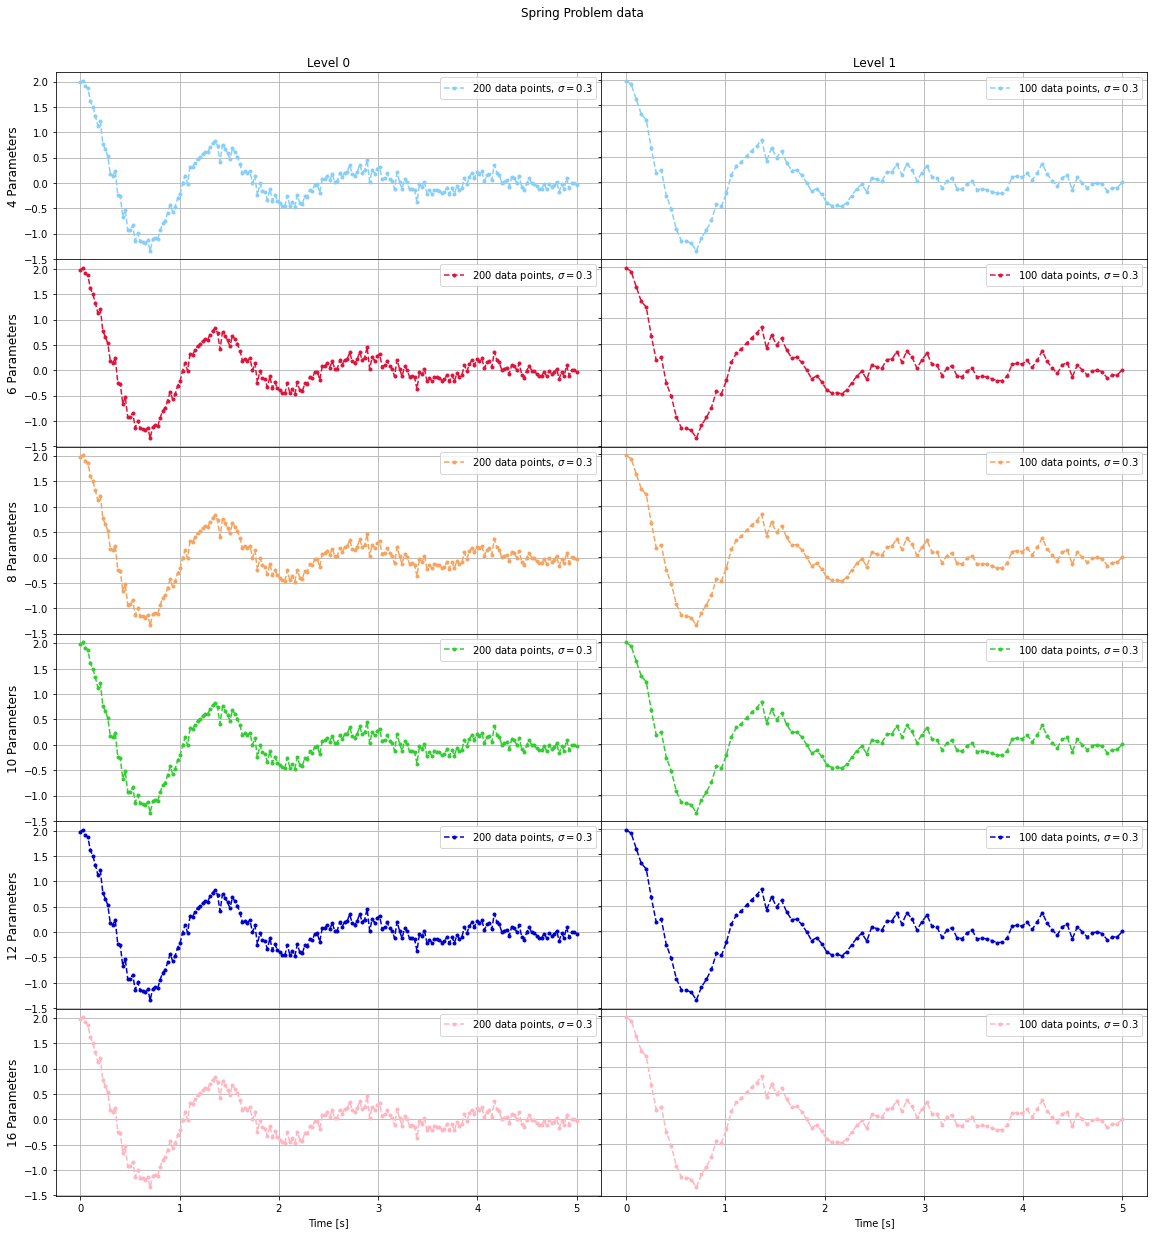

In [ ]:
datasets = []
method_names = []

# Add noise
sigma = 0.3
u_noisy = u_true + np.random.normal(0, sigma ** 2, u_true.shape)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("4 Parameters")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("6 Parameters")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("8 Parameters")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("10 Parameters")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("12 Parameters")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("16 Parameters")

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigma}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem data")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
# Set random process parameters.
# mkls = [4, 8, 10, 12, 16, 20, 32] # Number of parameters in model
mkls = [4, 6, 8, 10, 12, 16] # Number of parameters in model
lamb = 0.5 # Lengthscale in covariance matrix

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:

    # Generate covariance matrix
    t = np.linspace(0, T_max, data.shape[0])
    random_process = SquaredExponential(t, mkls[i], lamb, var = 1)
    random_process.compute_eigenpairs()

    logl.append(LogLike(my_loglik, data, random_process, T_max, sigma = 1.0))
  logls.append(logl)

Create fine and coarse models

In [ ]:
# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
all_fine_models = []
for i in range(len(datasets)):
  # Set prior parameters for multivariate Gaussian prior distribution.
  mu_prior = np.zeros((mkls[i],))
  cov_prior = np.eye(mkls[i])

  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkls[i],))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)
for i in range(len(datasets)):
  # Set prior parameters for multivariate Gaussian prior distribution.
  mu_prior = np.zeros((mkls[i],))
  cov_prior = np.eye(mkls[i])
  
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkls[i],))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 6000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 4000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  with fine_model:
    MAP = pm.find_MAP()

    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          return_inferencedata=False,
          cores=10,
          start=MAP,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                        start=MAP,
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 4_000 tune and 6_000 draw iterations (12_000 + 18_000 draws total) took 109 seconds.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 4_000 tune and 6_000 draw iterations (12_000 + 18_000 draws total) took 84 seconds.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 4_000 tune and 6_000 draw iterations (12_000 + 18_000 draws total) took 87 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 4_000 tune and 6_000 draw iterations (12_000 + 18_000 draws total) took 89 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 4_000 tune and 6_000 draw iterations (12_000 + 18_000 draws total) took 90 seconds.
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 4_000 tune and 6_000 draw iterations (12_000 + 18_000 draws total) took 95 seconds.
The number of effective samples is smaller than 10% for some parameters.


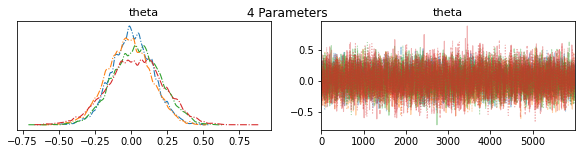

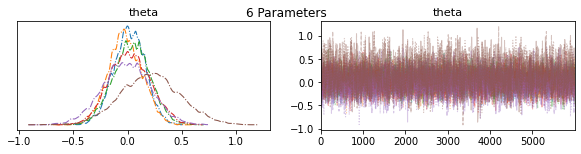

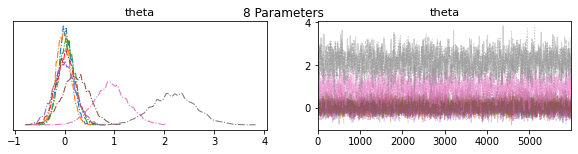

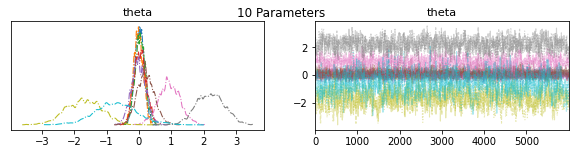

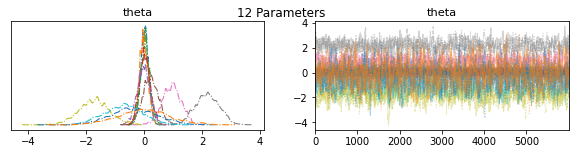

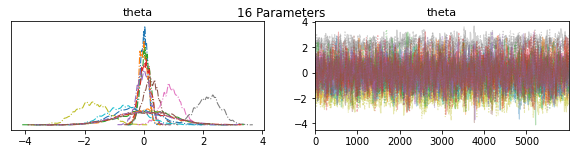

In [ ]:
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    f,ax = plt.subplots(1,2, figsize=(10,2))
    az.plot_trace(trace, axes = ax[None,:], compact = True, combined=True)
    f.suptitle(method_names[i])
    plt.show()

In [ ]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


4 Parameters Sampler:
 runtime :  109.52551794052124


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.009  0.142  -0.260    0.275  ...    0.002    3085.0    4403.0    1.0
theta[1] -0.017  0.152  -0.302    0.265  ...    0.002    3219.0    4269.0    1.0
theta[2]  0.041  0.165  -0.264    0.355  ...    0.002    2945.0    4343.0    1.0
theta[3]  0.031  0.194  -0.327    0.394  ...    0.002    3165.0    4240.0    1.0

[4 rows x 9 columns]


6 Parameters Sampler:
 runtime :  85.18076157569885


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.017  0.144  -0.247    0.291  ...    0.002    2144.0    3206.0    1.0
theta[1] -0.021  0.154  -0.309    0.262  ...    0.002    2195.0    3108.0    1.0
theta[2]  0.036  0.169  -0.292    0.341  ...    0.002    2328.0    3314.0    1.0
theta[3]  0.021  0.189  -0.311    0.395  ...    0.003    2057.0    3306.0    1.0
theta[4] -0.014  0.222  -0.444    0.388  ...    0.003    2077.0    3097.0    1.0
theta[5]  0.214  0.275  -0.302    0.731  ...    0.004    2321.0    3256.0    1.0

[6 rows x 9 columns]


8 Parameters Sampler:
 runtime :  87.7764880657196


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.018  0.144  -0.251    0.287  ...    0.002    1803.0    2968.0    1.0
theta[1] -0.024  0.148  -0.296    0.254  ...    0.003    1662.0    2759.0    1.0
theta[2]  0.047  0.164  -0.250    0.367  ...    0.003    1777.0    2732.0    1.0
theta[3]  0.026  0.194  -0.324    0.404  ...    0.003    1620.0    2338.0    1.0
theta[4] -0.006  0.224  -0.408    0.454  ...    0.004    1586.0    2117.0    1.0
theta[5]  0.218  0.270  -0.293    0.715  ...    0.005    1482.0    2765.0    1.0
theta[6]  0.929  0.340   0.268    1.552  ...    0.006    1409.0    2568.0    1.0
theta[7]  2.183  0.437   1.336    2.975  ...    0.008    1385.0    2142.0    1.0

[8 rows x 9 columns]


10 Parameters Sampler:
 runtime :  89.58445143699646


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.013  0.144  -0.255    0.287  ...    0.003     970.0    1395.0   1.00
theta[1] -0.019  0.149  -0.289    0.254  ...    0.003     990.0    1671.0   1.00
theta[2]  0.040  0.160  -0.255    0.344  ...    0.004     857.0    1170.0   1.00
theta[3]  0.036  0.188  -0.298    0.394  ...    0.005     686.0    1241.0   1.01
theta[4] -0.010  0.227  -0.434    0.411  ...    0.006     805.0    1398.0   1.00
theta[5]  0.205  0.269  -0.302    0.699  ...    0.007     823.0     944.0   1.00
theta[6]  0.935  0.335   0.286    1.566  ...    0.009     760.0    1134.0   1.01
theta[7]  2.207  0.432   1.447    3.043  ...    0.011     767.0    1387.0   1.00
theta[8] -1.705  0.556  -2.763   -0.711  ...    0.016     646.0     943.0   1.01
theta[9] -0.706  0.668  -1.888    0.676  ...    0.021     523.0     751.0   1.00

[10 rows x 9 columns]


12 Parameters Sampler:
 runtime :  91.2125334739685


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   0.013  0.140  -0.244    0.281  ...    0.003     855.0    1293.0   1.00
theta[1]  -0.018  0.149  -0.310    0.253  ...    0.004     840.0    1424.0   1.01
theta[2]   0.037  0.163  -0.279    0.340  ...    0.004     742.0     967.0   1.00
theta[3]   0.027  0.188  -0.318    0.396  ...    0.005     598.0    1308.0   1.00
theta[4]  -0.020  0.228  -0.442    0.409  ...    0.007     600.0    1202.0   1.01
theta[5]   0.222  0.269  -0.281    0.720  ...    0.008     591.0    1037.0   1.00
theta[6]   0.949  0.327   0.305    1.520  ...    0.008     747.0    1354.0   1.00
theta[7]   2.176  0.419   1.399    2.914  ...    0.012     567.0    1261.0   1.01
theta[8]  -1.726  0.541  -2.755   -0.704  ...    0.016     588.0     952.0   1.00
theta[9]  -0.722  0.669  -1.981    0.532  ...    0.021     487.0     784.0   1.01
theta[10] -0.349  0.814  -1.849    1.165  ...    0.023     613.0    1127.0   1.01
theta[11] -0.007  0.883  -1.769    1.598  ...    0.024     692.0     884.0   1.01

[12 rows x 9 columns]


16 Parameters Sampler:
 runtime :  95.65120220184326


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  -0.001  0.135  -0.255    0.250  ...    0.003     817.0    1305.0   1.00
theta[1]  -0.019  0.154  -0.277    0.284  ...    0.004     642.0    1323.0   1.01
theta[2]   0.050  0.166  -0.251    0.367  ...    0.004     705.0    1365.0   1.01
theta[3]   0.031  0.191  -0.332    0.369  ...    0.005     743.0    1402.0   1.00
theta[4]  -0.024  0.224  -0.445    0.391  ...    0.006     658.0    1051.0   1.01
theta[5]   0.228  0.264  -0.274    0.714  ...    0.008     594.0    1396.0   1.00
theta[6]   0.910  0.331   0.274    1.513  ...    0.009     625.0    1107.0   1.01
theta[7]   2.160  0.428   1.315    2.920  ...    0.013     537.0    1023.0   1.01
theta[8]  -1.772  0.540  -2.773   -0.804  ...    0.016     579.0    1030.0   1.00
theta[9]  -0.624  0.657  -1.847    0.578  ...    0.022     437.0     855.0   1.01
theta[10] -0.331  0.766  -1.749    1.109  ...    0.022     628.0    1071.0   1.01
theta[11]  0.043  0.865  -1.591    1.711  ...    0.025     608.0     827.0   1.01
theta[12]  0.073  0.907  -1.688    1.677  ...    0.025     654.0    1171.0   1.00
theta[13] -0.003  0.976  -1.835    1.798  ...    0.027     654.0    1017.0   1.01
theta[14]  0.006  0.908  -1.697    1.640  ...    0.028     534.0    1147.0   1.00
theta[15]  0.041  0.944  -1.800    1.687  ...    0.027     600.0    1018.0   1.00

[16 rows x 9 columns]

In [ ]:
# Model predictions
error = []
u_hats = []
for i,theta_hat in enumerate(theta_hats):
  u_hat = get_prediction(logls[i][0].random_process, theta_hat)
  mse = np.mean((u_true-u_hat)**2)
  u_hats.append(u_hat)
  error.append(mse)

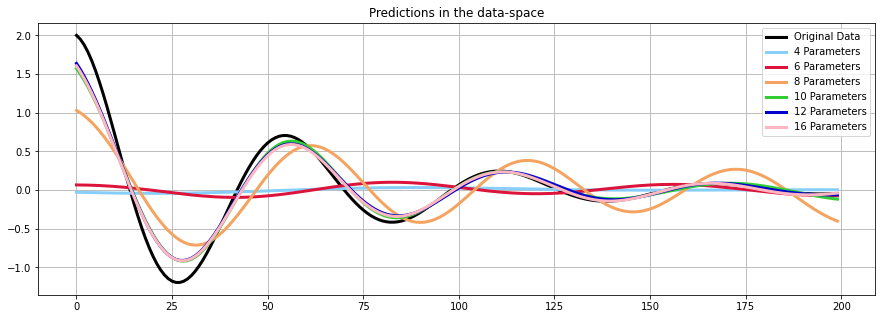

In [ ]:
f,ax = plt.subplots(figsize=(15,5))
ax.plot(u_true,'-k',lw=3,label="Original Data")
for i in range(len(all_traces)):
  ax.plot(u_hats[i],'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Predictions in the data-space")
plt.show()
f.savefig(image_folder + "predictions.png",bbox_inches='tight',dpi=300)

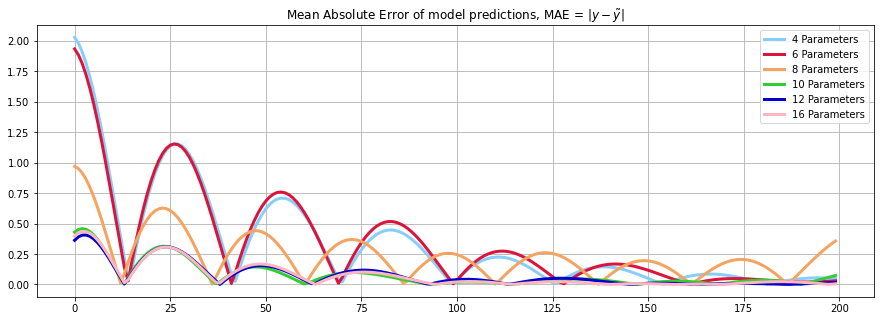

In [ ]:
f,ax = plt.subplots(figsize=(15,5))
for i in range(len(all_traces)):
  ax.plot(abs(u_true-u_hats[i]),'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Mean Absolute Error of model predictions, " + r"MAE = $|y-\tilde{y}|$")
plt.show()
f.savefig(image_folder + "MAE.png",bbox_inches='tight',dpi=300)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

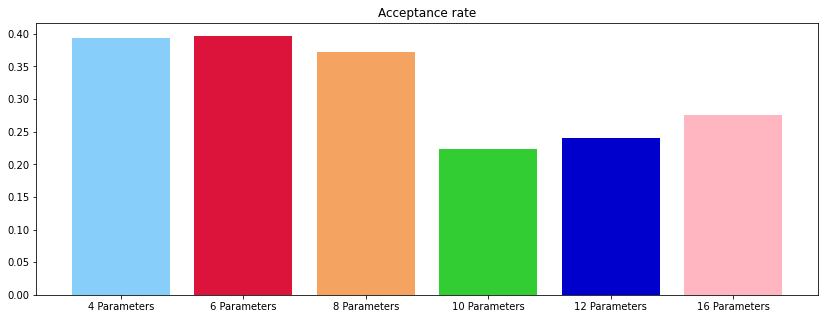

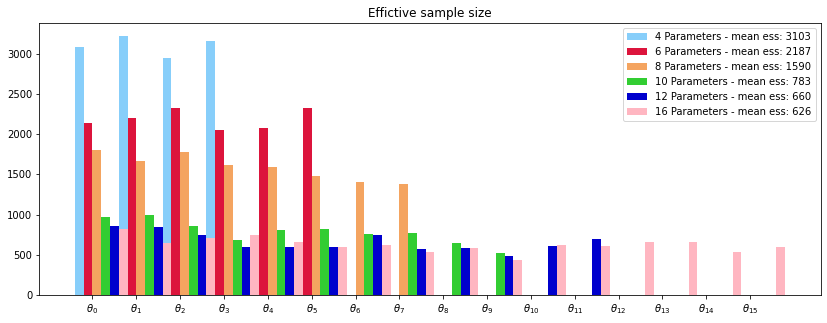

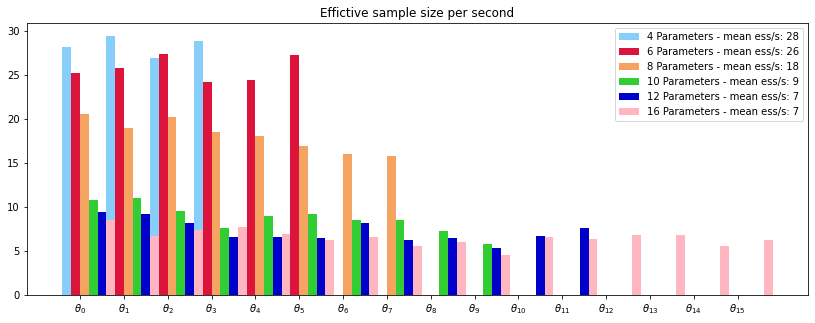

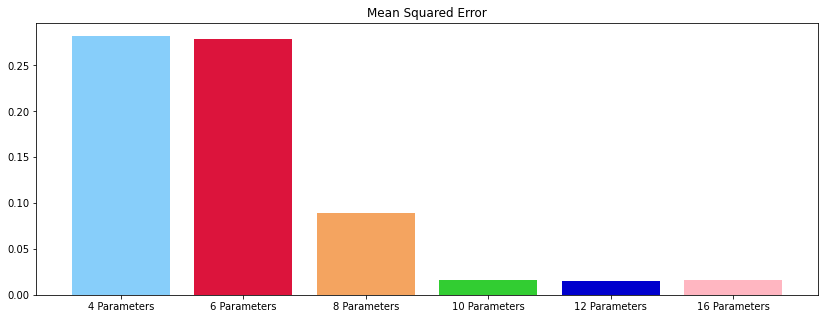

In [ ]:
# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)


f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size')
for i, e in enumerate(ess):
  e_new = np.concatenate((e,np.zeros(ess[-1].shape[0]-e.shape[0])))
  ax.bar(
      [j + i * 0.2 for j in range(mkls[-1])],
      e_new.ravel(),
      width=0.2,
      color=cols[i],
      label=method_names[i]+ f" - mean ess: {round(np.mean(e))}",
  )
ax.set_xticks([i + 0.3 for i in range(mkls[-1])])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkls[-1])])
ax.legend()
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size per second')
for i, p in enumerate(performances):
  p_new = np.concatenate((p,np.zeros(performances[-1].shape[0]-p.shape[0])))
  ax.bar(
      [j + i * 0.2 for j in range(mkls[-1])],
      p_new.ravel(),
      width=0.2,
      color=cols[i],
      label=method_names[i] + f" - mean ess/s: {round(np.mean(p))}",
  )
ax.set_xticks([i + 0.3 for i in range(mkls[-1])])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkls[-1])])
ax.legend()
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Kernel Variance test

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "kernel_variance_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 200
t = np.linspace(0, T_max, size)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

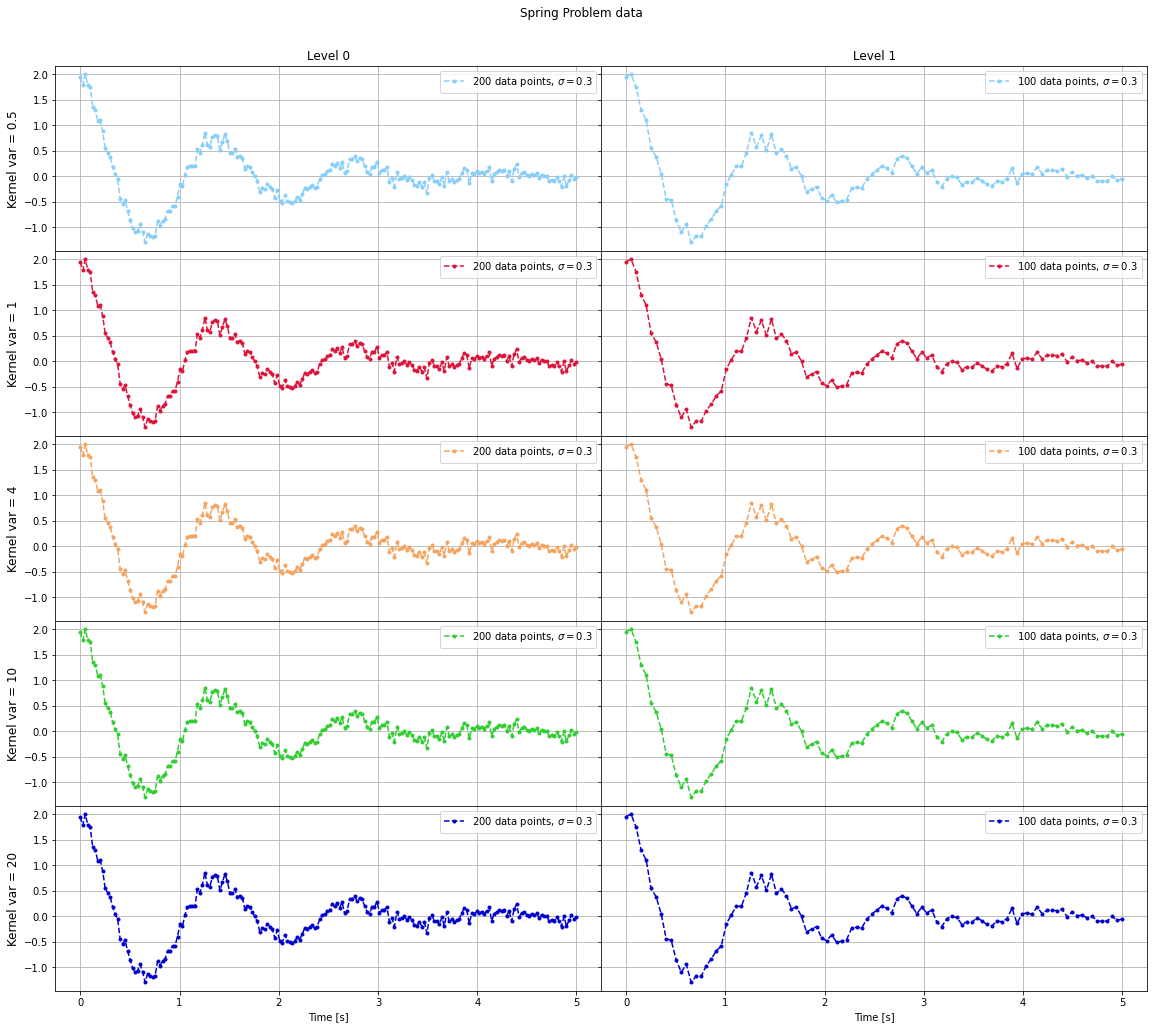

In [ ]:
datasets = []
method_names = []

# Add noise
sigma = 0.3
u_noisy = u_true + np.random.normal(0, sigma ** 2, u_true.shape)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("Kernel var = 0.5")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("Kernel var = 1")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("Kernel var = 4")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("Kernel var = 10")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("Kernel var = 20")
cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigma}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem data")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
# Set random process parameters.
mkl = 10 # Number of parameters in model
lamb = 0.5 # Lengthscale in covariance matrix
vars = [0.5, 1, 4, 10, 20]

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:

    # Generate covariance matrix
    t = np.linspace(0, T_max, data.shape[0])
    random_process = SquaredExponential(t, mkl, lamb, var = vars[i])
    random_process.compute_eigenpairs()

    logl.append(LogLike(my_loglik, data, random_process, T_max, sigma = 1.0))
  logls.append(logl)

Create fine and coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros((mkl,))
cov_prior = np.eye(mkl)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
all_fine_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)
for i in range(len(datasets)): 
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 3000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 2000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,3]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  with fine_model:
    if i == 0:
      MAP = pm.find_MAP()

    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          return_inferencedata=False,
          cores=10,
          start=MAP,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                        start=MAP,
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 76 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 62 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 55 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 43 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


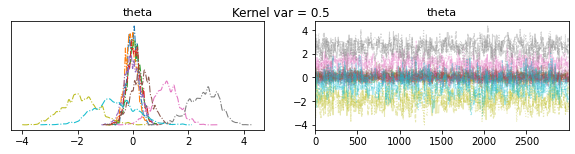

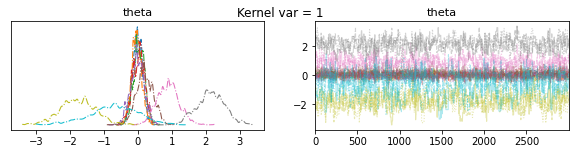

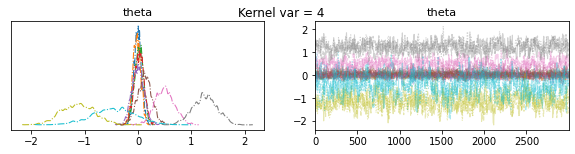

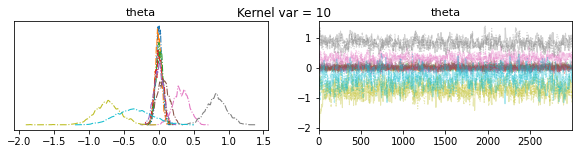

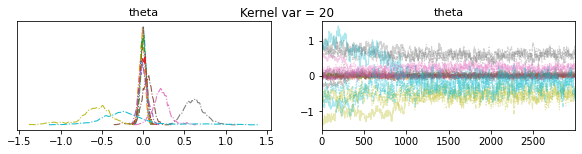

In [ ]:
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    f,ax = plt.subplots(1,2, figsize=(10,2))
    az.plot_trace(trace, axes = ax[None,:], compact = True, combined=True)
    f.suptitle(method_names[i])
    plt.show()

In [ ]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Kernel var = 0.5 Sampler:
 runtime :  77.05393719673157


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.012  0.198  -0.366    0.375  ...    0.006     469.0     641.0   1.01
theta[1] -0.081  0.207  -0.471    0.297  ...    0.007     414.0     696.0   1.01
theta[2]  0.054  0.234  -0.342    0.531  ...    0.007     498.0     731.0   1.02
theta[3]  0.032  0.246  -0.384    0.534  ...    0.008     499.0     738.0   1.00
theta[4] -0.034  0.287  -0.587    0.477  ...    0.010     431.0     849.0   1.01
theta[5]  0.283  0.366  -0.445    0.937  ...    0.013     405.0     494.0   1.01
theta[6]  1.163  0.465   0.226    1.986  ...    0.016     405.0     732.0   1.01
theta[7]  2.553  0.544   1.519    3.493  ...    0.020     371.0     696.0   1.01
theta[8] -1.896  0.657  -3.131   -0.674  ...    0.024     375.0     509.0   1.00
theta[9] -0.646  0.758  -1.883    0.826  ...    0.034     247.0     363.0   1.02

[10 rows x 9 columns]


Kernel var = 1 Sampler:
 runtime :  63.3012969493866


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.010  0.146  -0.290    0.242  ...    0.005     453.0     748.0   1.01
theta[1] -0.033  0.150  -0.303    0.273  ...    0.005     458.0     730.0   1.01
theta[2]  0.038  0.168  -0.285    0.350  ...    0.006     443.0     690.0   1.01
theta[3]  0.018  0.182  -0.282    0.392  ...    0.006     493.0     729.0   1.01
theta[4] -0.018  0.204  -0.403    0.351  ...    0.007     423.0     553.0   1.01
theta[5]  0.199  0.256  -0.253    0.681  ...    0.009     453.0     628.0   1.00
theta[6]  0.889  0.326   0.294    1.491  ...    0.011     399.0     907.0   1.01
theta[7]  2.149  0.417   1.338    2.876  ...    0.015     397.0     537.0   1.00
theta[8] -1.772  0.527  -2.760   -0.818  ...    0.021     318.0     427.0   1.01
theta[9] -0.706  0.721  -2.027    0.709  ...    0.039     178.0     258.0   1.02

[10 rows x 9 columns]


Kernel var = 4 Sampler:
 runtime :  55.945473432540894


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.006  0.070  -0.141    0.119  ...    0.002     524.0     858.0   1.01
theta[1] -0.027  0.073  -0.167    0.106  ...    0.003     413.0     722.0   1.01
theta[2]  0.017  0.085  -0.142    0.171  ...    0.003     511.0     857.0   1.00
theta[3]  0.018  0.091  -0.164    0.174  ...    0.003     466.0     759.0   1.01
theta[4] -0.005  0.114  -0.211    0.208  ...    0.003     551.0     841.0   1.01
theta[5]  0.123  0.138  -0.140    0.376  ...    0.004     482.0     734.0   1.00
theta[6]  0.498  0.183   0.170    0.852  ...    0.007     304.0     819.0   1.02
theta[7]  1.249  0.228   0.841    1.682  ...    0.008     410.0     956.0   1.02
theta[8] -1.130  0.313  -1.761   -0.595  ...    0.010     516.0     852.0   1.01
theta[9] -0.452  0.407  -1.227    0.287  ...    0.017     304.0     582.0   1.01

[10 rows x 9 columns]


Kernel var = 10 Sampler:
 runtime :  43.33338189125061


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.003  0.043  -0.077    0.085  ...    0.002     372.0     707.0   1.01
theta[1] -0.009  0.045  -0.097    0.067  ...    0.001     477.0     841.0   1.00
theta[2]  0.008  0.052  -0.096    0.096  ...    0.002     458.0     858.0   1.01
theta[3]  0.004  0.059  -0.113    0.105  ...    0.002     385.0     917.0   1.00
theta[4] -0.001  0.070  -0.135    0.124  ...    0.002     460.0    1026.0   1.01
theta[5]  0.060  0.087  -0.111    0.212  ...    0.003     425.0     801.0   1.00
theta[6]  0.316  0.113   0.093    0.516  ...    0.004     474.0     836.0   1.01
theta[7]  0.826  0.150   0.540    1.107  ...    0.005     449.0     644.0   1.01
theta[8] -0.738  0.192  -1.073   -0.366  ...    0.007     497.0     818.0   1.01
theta[9] -0.356  0.261  -0.808    0.172  ...    0.011     295.0     742.0   1.02

[10 rows x 9 columns]


Kernel var = 20 Sampler:
 runtime :  45.46099805831909


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.001  0.032  -0.063    0.054  ...    0.001     315.0     719.0   1.02
theta[1] -0.014  0.035  -0.082    0.049  ...    0.002     210.0     610.0   1.01
theta[2]  0.006  0.036  -0.059    0.072  ...    0.002     243.0     733.0   1.02
theta[3]  0.001  0.043  -0.077    0.080  ...    0.002     229.0     532.0   1.02
theta[4]  0.002  0.055  -0.095    0.115  ...    0.005      76.0      35.0   1.04
theta[5]  0.043  0.079  -0.083    0.194  ...    0.011      49.0      20.0   1.05
theta[6]  0.218  0.101   0.025    0.406  ...    0.010      71.0      35.0   1.07
theta[7]  0.620  0.124   0.379    0.844  ...    0.024      19.0      19.0   1.11
theta[8] -0.602  0.213  -1.088   -0.241  ...    0.060      13.0      11.0   1.16
theta[9] -0.182  0.382  -0.879    0.714  ...    0.117       8.0      11.0   1.30

[10 rows x 9 columns]

In [ ]:
# Model predictions
error = []
u_hats = []
for i,theta_hat in enumerate(theta_hats):
  u_hat = get_prediction(logls[i][0].random_process, theta_hat)
  mse = np.mean((u_true-u_hat)**2)
  u_hats.append(u_hat)
  error.append(mse)

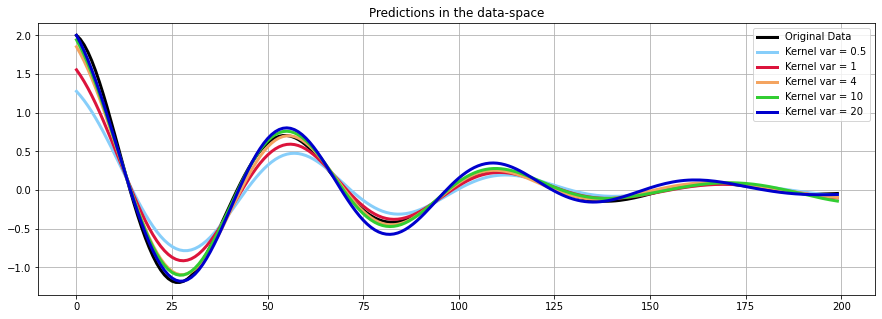

In [ ]:
f,ax = plt.subplots(figsize=(15,5))
ax.plot(u_true,'-k',lw=3,label="Original Data")
for i in range(len(all_traces)):
  ax.plot(u_hats[i],'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Predictions in the data-space")
plt.show()
f.savefig(image_folder + "predictions.png",bbox_inches='tight',dpi=300)

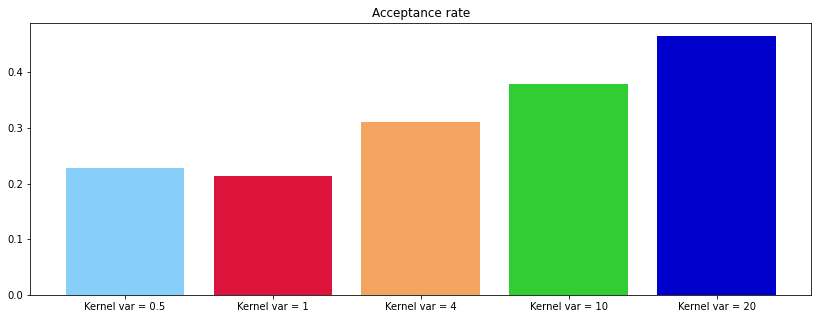

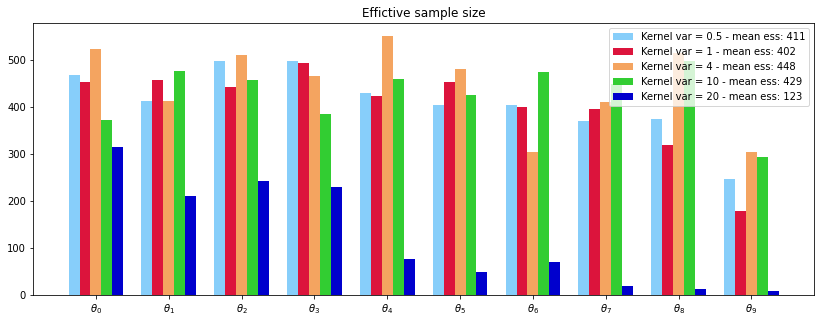

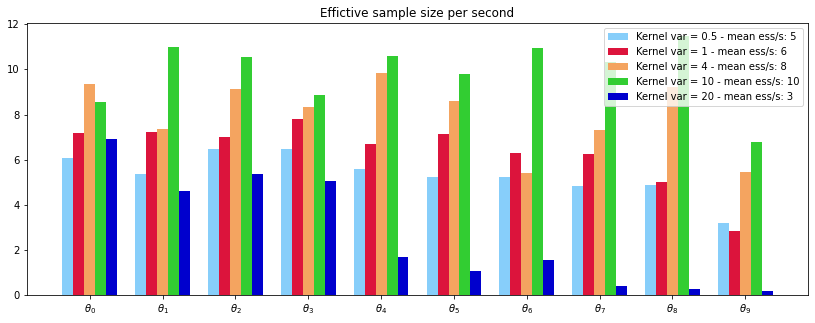

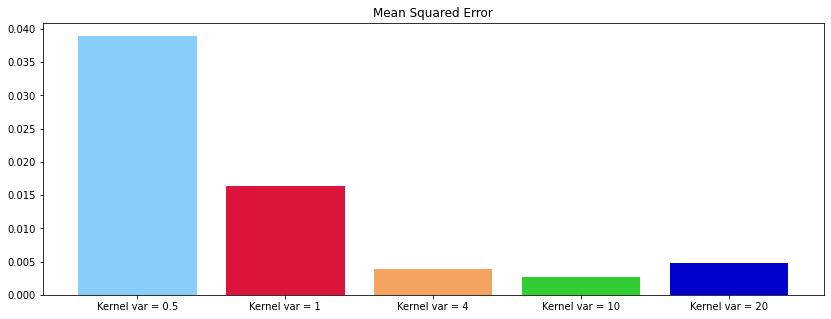

In [ ]:
# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)


f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size')
for i, e in enumerate(ess):
    ax.bar(
        [j + i * 0.15 for j in range(mkl)],
        e.ravel(),
        width=0.15,
        color=cols[i],
        label=method_names[i] + f" - mean ess: {round(np.mean(e))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size per second')
for i, p in enumerate(performances):
    ax.bar(
        [j + i * 0.15 for j in range(mkl)],
        p.ravel(),
        width=0.15,
        color=cols[i],
        label=method_names[i] + f" - mean ess/s: {round(np.mean(p))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Proposal Variance test

In [5]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "proposal_variance_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 200
t = np.linspace(0, T_max, size)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

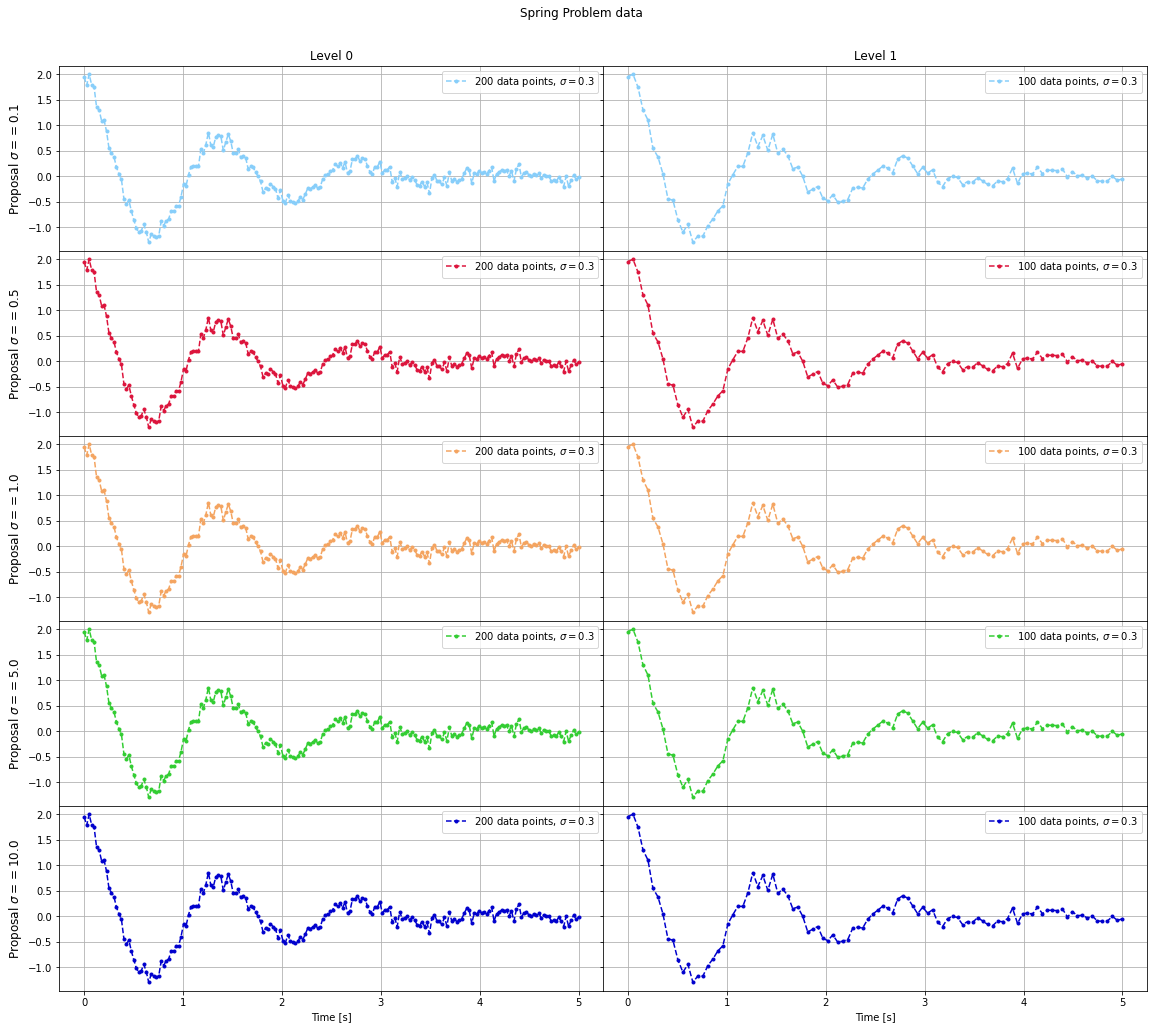

In [11]:
datasets = []
method_names = []

# Add noise
sigma = 0.3
u_noisy = u_true + np.random.normal(0, sigma ** 2, u_true.shape)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = = 0.1$")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = = 0.5$")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = = 1.0$")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = = 5.0$")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = = 10.0$")


cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigma}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem data")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [12]:
# Set random process parameters.
mkl = 10 # Number of parameters in model
lamb = 0.5 # Lengthscale in covariance matrix
var = 4

In [13]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:

    # Generate covariance matrix
    t = np.linspace(0, T_max, data.shape[0])
    random_process = SquaredExponential(t, mkl, lamb, var = var)
    random_process.compute_eigenpairs()

    logl.append(LogLike(my_loglik, data, random_process, T_max, sigma = 1.0))
  logls.append(logl)

Create fine and coarse models

In [14]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros((mkl,))
cov_prior = np.eye(mkl)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
all_fine_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)
for i in range(len(datasets)): 
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [30]:
# Number of draws from the distribution
ndraws = 6000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 2000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,3]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

# Proposal variance
Ss = [0.1, 0.5, 1.0, 5.0, 10.0]
# Ss = [np.asarray(0.1), np.asarray(0.5), np.asarray(1.0), np.asarray(5.0), np.asarray(10.0)]

In [31]:
help(pm.MLDA)

Help on class MLDA in module pymc3.step_methods.mlda:

class MLDA(pymc3.step_methods.arraystep.ArrayStepShared)
 |  MLDA(*args, **kwargs)
 |  
 |  Multi-Level Delayed Acceptance (MLDA) sampling step that uses coarse
 |  approximations of a fine model to construct proposals in multiple levels.
 |  
 |  MLDA creates a hierarchy of MCMC chains. Chains sample from different
 |  posteriors that ideally should be approximations of the fine (top-level)
 |  posterior and require less computational effort to evaluate their likelihood.
 |  
 |  Each chain runs for a fixed number of iterations (up to subsampling_rate) and
 |  then the last sample generated is used as a proposal for the chain in the level
 |  above (excluding when variance reduction is used, where a random sample from
 |  the generated sequence is used). The bottom-level chain is a MetropolisMLDA
 |  or DEMetropolisZMLDA sampler.
 |  
 |  The algorithm achieves higher acceptance rate and effective sample sizes
 |  than other sampl

In [32]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  with fine_model:
    if i == 0:
      MAP = pm.find_MAP()

    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          return_inferencedata=False,
          cores=10,
          start=MAP,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)],
          base_scaling = Ss[i],
          # base_S = Ss[i],
          base_sampler = "Metropolis"
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                        start=MAP,
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 104 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 79 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 77 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 77 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 77 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


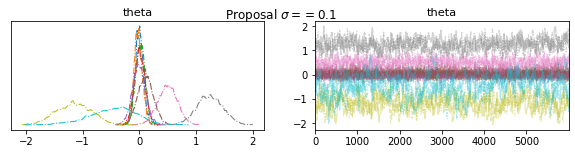

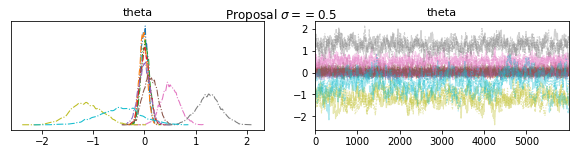

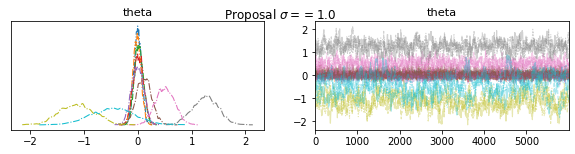

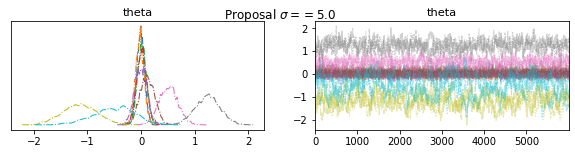

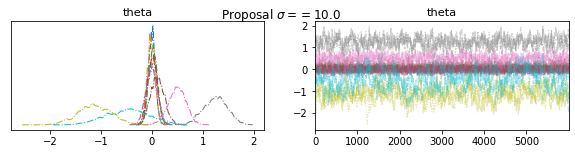

In [33]:
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    f,ax = plt.subplots(1,2, figsize=(10,2))
    az.plot_trace(trace, axes = ax[None,:], compact = True, combined=True)
    f.suptitle(method_names[i])
    plt.show()

In [34]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Proposal $\sigma = = 0.1$ Sampler:
 runtime :  104.8840560913086


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.004  0.072  -0.135    0.132  ...    0.001    2696.0    4092.0   1.00
theta[1] -0.022  0.075  -0.162    0.120  ...    0.001    2567.0    4054.0   1.00
theta[2]  0.018  0.082  -0.141    0.163  ...    0.001    2302.0    3682.0   1.00
theta[3]  0.007  0.093  -0.175    0.177  ...    0.001    1998.0    3150.0   1.00
theta[4] -0.010  0.114  -0.231    0.203  ...    0.002    1370.0    2210.0   1.00
theta[5]  0.110  0.138  -0.139    0.377  ...    0.003    1160.0    1904.0   1.00
theta[6]  0.495  0.173   0.181    0.826  ...    0.005     733.0    1403.0   1.00
theta[7]  1.242  0.229   0.801    1.661  ...    0.008     366.0     902.0   1.00
theta[8] -1.153  0.310  -1.718   -0.585  ...    0.014     243.0     547.0   1.00
theta[9] -0.463  0.412  -1.312    0.237  ...    0.028     105.0     270.0   1.01

[10 rows x 9 columns]


Proposal $\sigma = = 0.5$ Sampler:
 runtime :  80.1053729057312


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.004  0.072  -0.138    0.133  ...    0.001    2549.0    3447.0   1.00
theta[1] -0.019  0.076  -0.163    0.122  ...    0.001    2412.0    3679.0   1.00
theta[2]  0.019  0.084  -0.130    0.185  ...    0.001    2259.0    3744.0   1.00
theta[3]  0.009  0.095  -0.159    0.193  ...    0.002    1870.0    3173.0   1.00
theta[4] -0.003  0.116  -0.217    0.217  ...    0.002    1301.0    2162.0   1.00
theta[5]  0.115  0.137  -0.129    0.373  ...    0.003    1044.0    1985.0   1.00
theta[6]  0.504  0.177   0.174    0.842  ...    0.005     699.0    1273.0   1.00
theta[7]  1.260  0.235   0.793    1.688  ...    0.009     375.0     685.0   1.01
theta[8] -1.146  0.314  -1.719   -0.551  ...    0.016     186.0     372.0   1.01
theta[9] -0.481  0.423  -1.241    0.352  ...    0.037      66.0     132.0   1.04

[10 rows x 9 columns]


Proposal $\sigma = = 1.0$ Sampler:
 runtime :  77.520663022995


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.003  0.072  -0.134    0.135  ...    0.001    2907.0    4229.0   1.00
theta[1] -0.019  0.076  -0.160    0.128  ...    0.001    2460.0    3519.0   1.00
theta[2]  0.017  0.083  -0.131    0.174  ...    0.001    2050.0    3719.0   1.00
theta[3]  0.011  0.096  -0.165    0.191  ...    0.002    1796.0    2741.0   1.00
theta[4] -0.009  0.113  -0.225    0.193  ...    0.002    1353.0    2232.0   1.00
theta[5]  0.115  0.139  -0.155    0.362  ...    0.003     900.0    1476.0   1.00
theta[6]  0.504  0.177   0.170    0.820  ...    0.005     690.0    1307.0   1.00
theta[7]  1.256  0.236   0.806    1.682  ...    0.008     401.0     830.0   1.00
theta[8] -1.133  0.324  -1.706   -0.537  ...    0.016     220.0     507.0   1.01
theta[9] -0.467  0.406  -1.250    0.256  ...    0.032      79.0     229.0   1.03

[10 rows x 9 columns]


Proposal $\sigma = = 5.0$ Sampler:
 runtime :  77.51068949699402


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.005  0.071  -0.138    0.132  ...    0.001    2699.0    3917.0   1.00
theta[1] -0.022  0.077  -0.169    0.121  ...    0.001    2180.0    3607.0   1.00
theta[2]  0.018  0.084  -0.141    0.170  ...    0.001    2237.0    3519.0   1.00
theta[3]  0.009  0.095  -0.165    0.193  ...    0.002    1775.0    2875.0   1.00
theta[4] -0.005  0.116  -0.234    0.203  ...    0.002    1134.0    2181.0   1.00
theta[5]  0.116  0.137  -0.138    0.364  ...    0.003     972.0    1645.0   1.00
theta[6]  0.509  0.174   0.190    0.839  ...    0.005     639.0    1177.0   1.00
theta[7]  1.241  0.236   0.790    1.673  ...    0.008     427.0     735.0   1.00
theta[8] -1.147  0.325  -1.749   -0.531  ...    0.016     213.0     524.0   1.01
theta[9] -0.505  0.391  -1.275    0.180  ...    0.031      81.0     193.0   1.02

[10 rows x 9 columns]


Proposal $\sigma = = 10.0$ Sampler:
 runtime :  78.1070864200592


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0] -0.002  0.071  -0.138    0.129  ...    0.001    2890.0    4100.0   1.00
theta[1] -0.021  0.077  -0.166    0.117  ...    0.001    2201.0    3597.0   1.00
theta[2]  0.021  0.083  -0.134    0.174  ...    0.001    2044.0    3221.0   1.00
theta[3]  0.014  0.097  -0.172    0.193  ...    0.002    1690.0    2749.0   1.00
theta[4] -0.007  0.114  -0.223    0.197  ...    0.002    1439.0    2332.0   1.00
theta[5]  0.108  0.136  -0.140    0.369  ...    0.003    1143.0    2047.0   1.00
theta[6]  0.495  0.175   0.164    0.814  ...    0.005     702.0    1080.0   1.00
theta[7]  1.248  0.233   0.835    1.690  ...    0.008     402.0     925.0   1.00
theta[8] -1.130  0.332  -1.757   -0.517  ...    0.019     174.0     395.0   1.02
theta[9] -0.475  0.425  -1.237    0.333  ...    0.031      97.0     289.0   1.04

[10 rows x 9 columns]

In [35]:
# Model predictions
error = []
u_hats = []
for i,theta_hat in enumerate(theta_hats):
  u_hat = get_prediction(logls[i][0].random_process, theta_hat)
  mse = np.mean((u_true-u_hat)**2)
  u_hats.append(u_hat)
  error.append(mse)

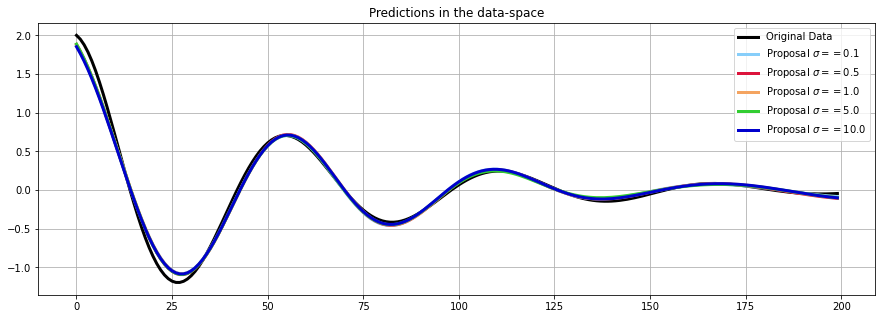

In [36]:
f,ax = plt.subplots(figsize=(15,5))
ax.plot(u_true,'-k',lw=3,label="Original Data")
for i in range(len(all_traces)):
  ax.plot(u_hats[i],'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Predictions in the data-space")
plt.show()
f.savefig(image_folder + "predictions.png",bbox_inches='tight',dpi=300)

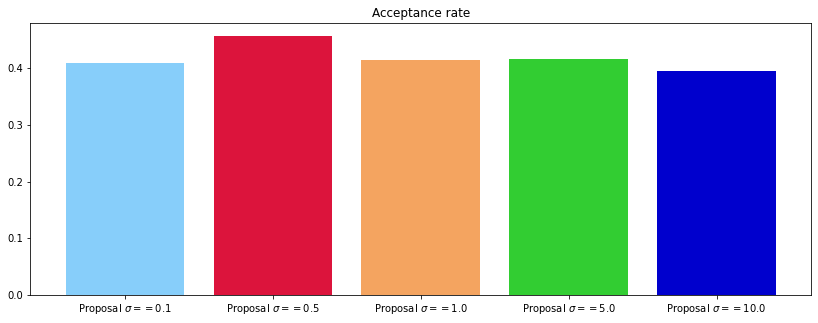

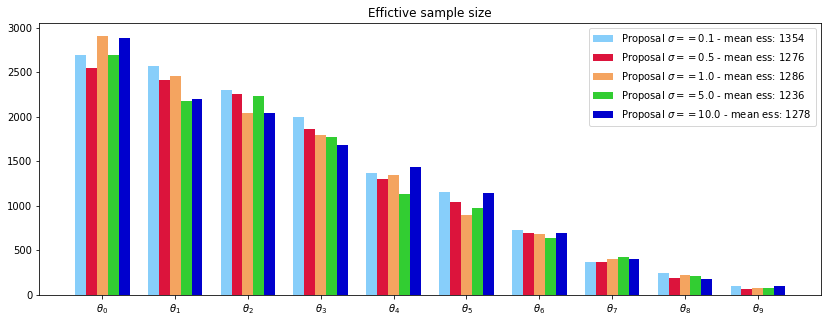

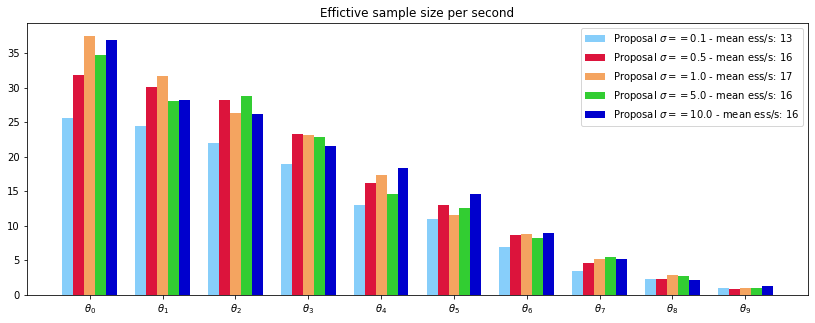

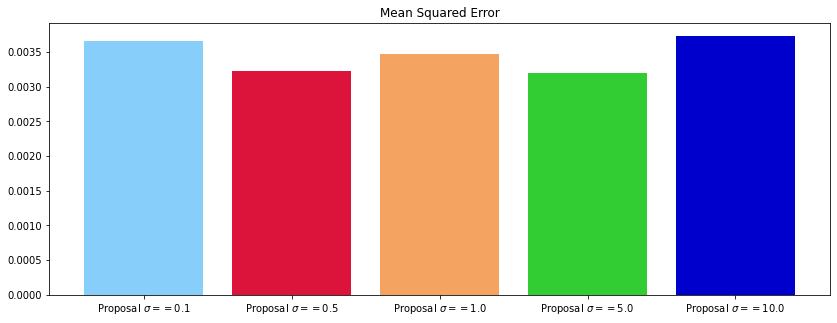

In [37]:
# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)


f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size')
for i, e in enumerate(ess):
    ax.bar(
        [j + i * 0.15 for j in range(mkl)],
        e.ravel(),
        width=0.15,
        color=cols[i],
        label=method_names[i] + f" - mean ess: {round(np.mean(e))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size per second')
for i, p in enumerate(performances):
    ax.bar(
        [j + i * 0.15 for j in range(mkl)],
        p.ravel(),
        width=0.15,
        color=cols[i],
        label=method_names[i] + f" - mean ess/s: {round(np.mean(p))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Effect of lengthscale

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "lengthscale_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 200
t = np.linspace(0, T_max, size)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

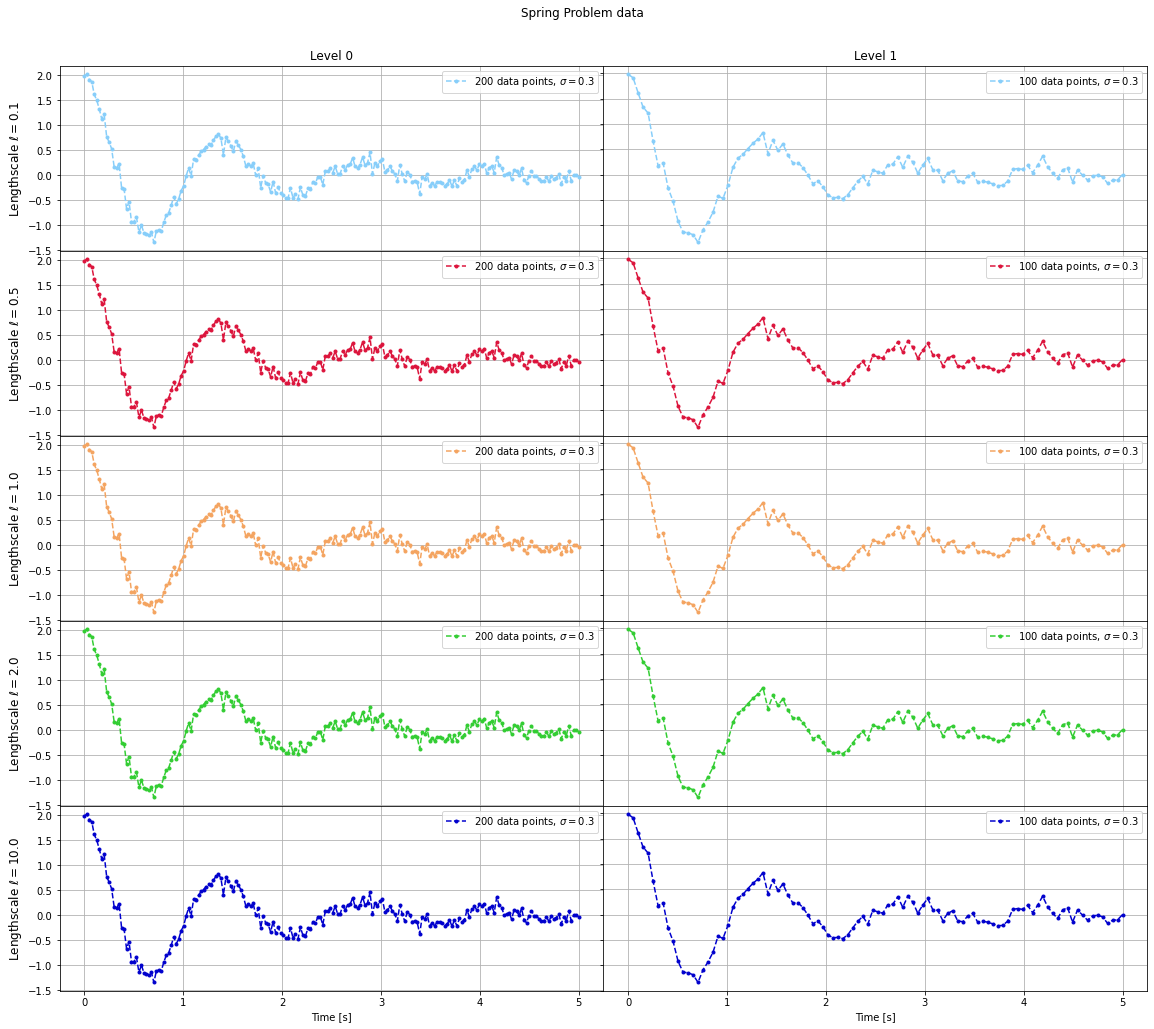

In [ ]:
datasets = []
method_names = []

# Add noise
sigma = 0.3
u_noisy = u_true + np.random.normal(0, sigma ** 2, u_true.shape)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Lengthscale $\ell = 0.1$")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Lengthscale $\ell = 0.5$")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Lengthscale $\ell = 1.0$")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Lengthscale $\ell = 2.0$")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append(r"Lengthscale $\ell = 10.0$")

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigma}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem data")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
# Set random process parameters.
mkl = 10 # Number of parameters in model
lambs = [0.1,0.5,1.0, 2.0,10.0] # Lengthscale in covariance matrix
var = 4

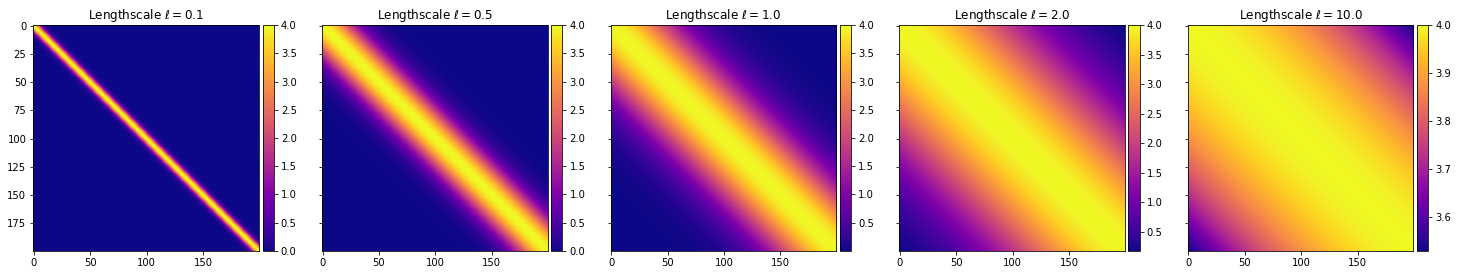

In [ ]:
covs = []
for i in range(len(lambs)):
  t = np.linspace(0, T_max, u_true.shape[0])
  random_process = SquaredExponential(t, mkl, lambs[i], var = var)
  cov = random_process.cov
  covs.append(cov)

from mpl_toolkits.axes_grid1 import make_axes_locatable

f,ax = plt.subplots(1,len(covs), figsize=(25,5), sharey=True)
for i,cov in enumerate(covs):
  im = ax[i].imshow(cov, cmap='plasma')
  divider = make_axes_locatable(ax[i])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  f.colorbar(im, cax=cax, orientation='vertical')
  ax[i].set_title(method_names[i])
plt.show()
f.savefig(image_folder + "Kernel Priors.png",bbox_inches='tight',dpi=400)

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:

    # Generate covariance matrix
    t = np.linspace(0, T_max, data.shape[0])
    random_process = SquaredExponential(t, mkl, lambs[i], var = var)
    random_process.compute_eigenpairs()

    logl.append(LogLike(my_loglik, data, random_process, T_max, sigma = 1.0))
  logls.append(logl)

Create fine and coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros((mkl,))
cov_prior = np.eye(mkl)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
all_fine_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)
for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 3000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 2000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,3]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  with fine_model:
    if i == 0:
      MAP = pm.find_MAP()

    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          return_inferencedata=False,
          cores=10,
          start=MAP,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                        start=MAP,
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 75 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 42 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 44 seconds.
The number of effective samples is smaller than 10% for some parameters.


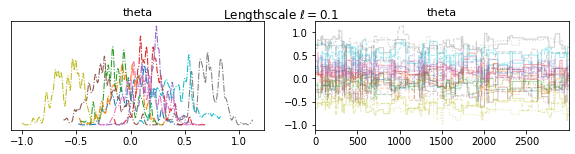

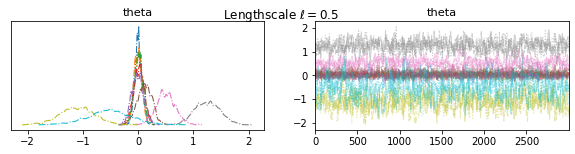

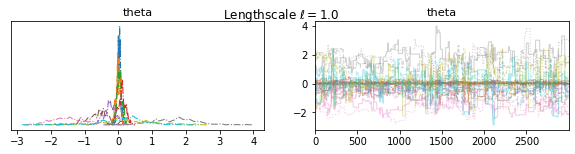

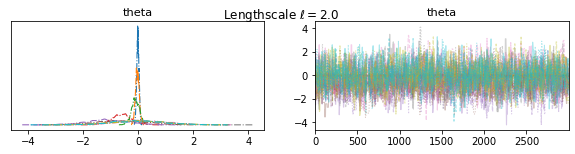

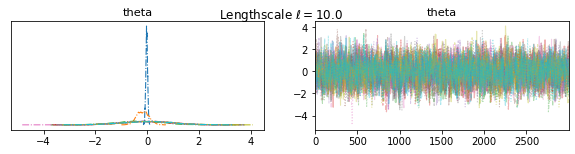

In [ ]:
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    f,ax = plt.subplots(1,2, figsize=(10,2))
    az.plot_trace(trace, axes = ax[None,:], compact = True, combined=True)
    f.suptitle(method_names[i])
    plt.show()

In [ ]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    # print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    # display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))

In [ ]:
# Model predictions
error = []
u_hats = []
for i,theta_hat in enumerate(theta_hats):
  u_hat = get_prediction(logls[i][0].random_process, theta_hat)
  mse = np.mean((u_true-u_hat)**2)
  u_hats.append(u_hat)
  error.append(mse)

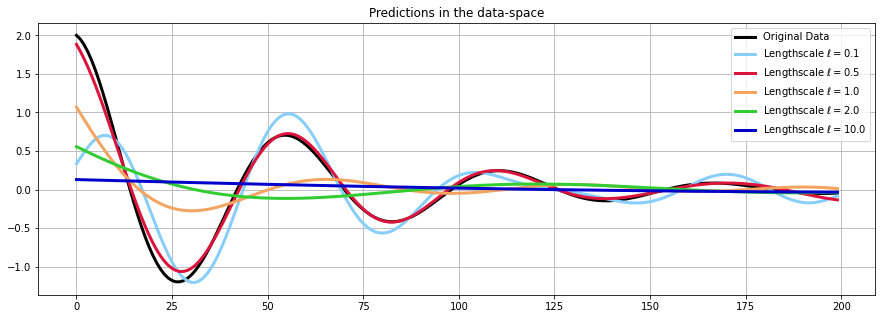

In [ ]:
f,ax = plt.subplots(figsize=(15,5))
ax.plot(u_true,'-k',lw=3,label="Original Data")
for i in range(len(all_traces)):
  ax.plot(u_hats[i],'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Predictions in the data-space")
plt.show()
f.savefig(image_folder + "predictions.png",bbox_inches='tight',dpi=300)

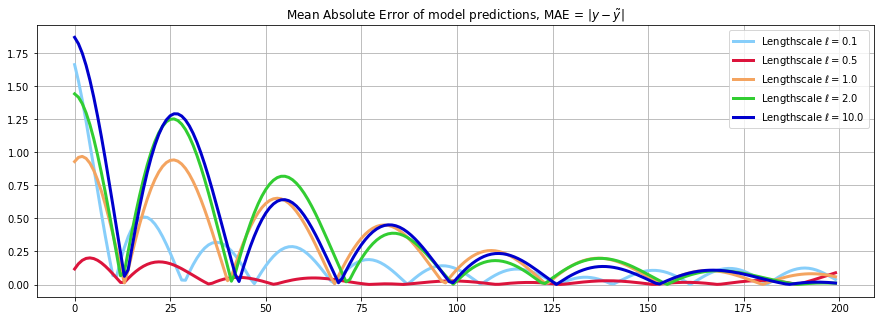

In [ ]:
f,ax = plt.subplots(figsize=(15,5))
for i in range(len(all_traces)):
  ax.plot(abs(u_true-u_hats[i]),'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Mean Absolute Error of model predictions, " + r"MAE = $|y-\tilde{y}|$")
plt.show()
f.savefig(image_folder + "MAE.png",bbox_inches='tight',dpi=300)

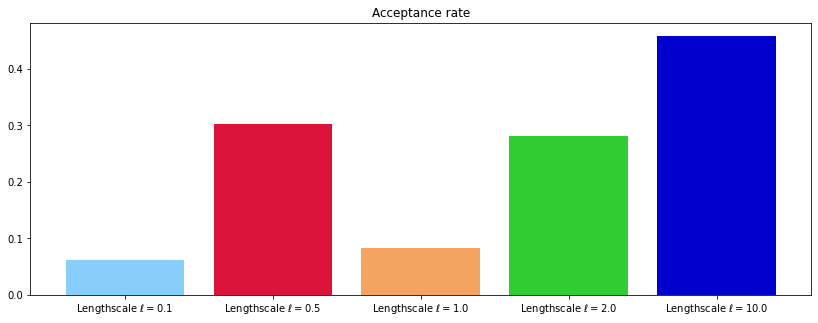

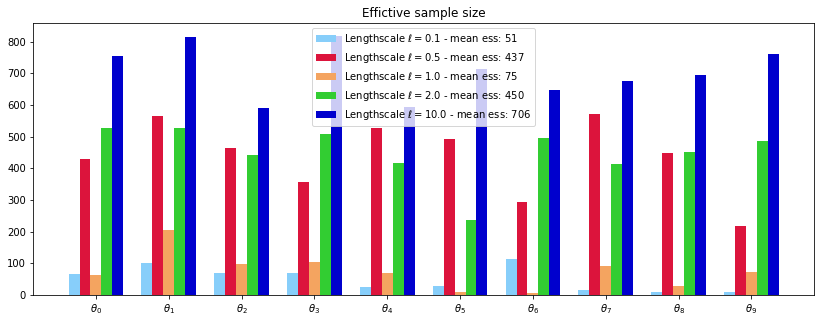

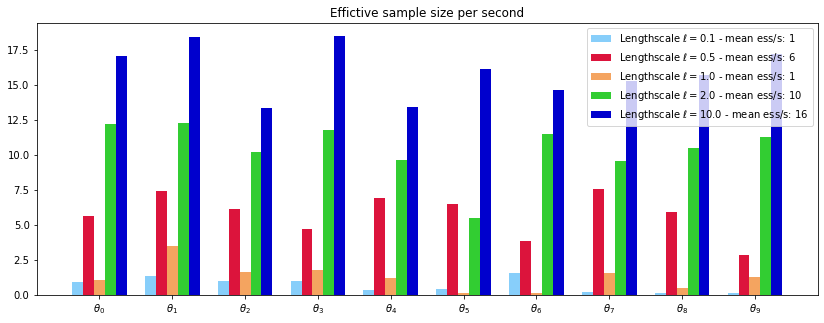

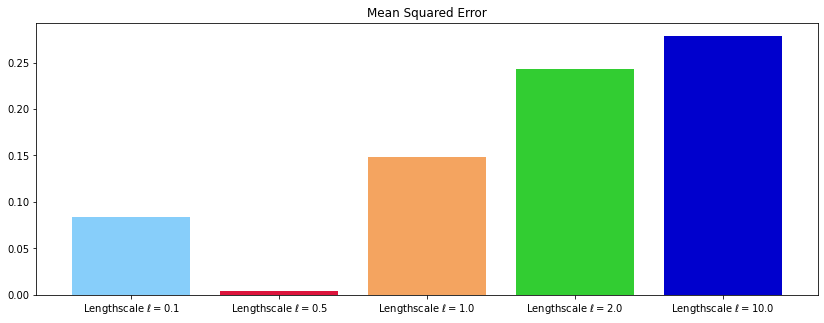

In [ ]:
# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)


f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size')
for i, e in enumerate(ess):
    ax.bar(
        [j + i * 0.15 for j in range(mkl)],
        e.ravel(),
        width=0.15,
        color=cols[i],
        label=method_names[i] + f" - mean ess: {round(np.mean(e))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size per second')
for i, p in enumerate(performances):
    ax.bar(
        [j + i * 0.15 for j in range(mkl)],
        p.ravel(),
        width=0.15,
        color=cols[i],
        label=method_names[i] + f" - mean ess/s: {round(np.mean(p))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Different kernels

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "different_kernel_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 200
t = np.linspace(0, T_max, size)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

In [ ]:
print(get_all_kernel_names())

['SquaredExponential', 'Matern52', 'RationalQuadraticKernel', 'ExpSineSquaredKernel', 'SquaredExponential_combined']


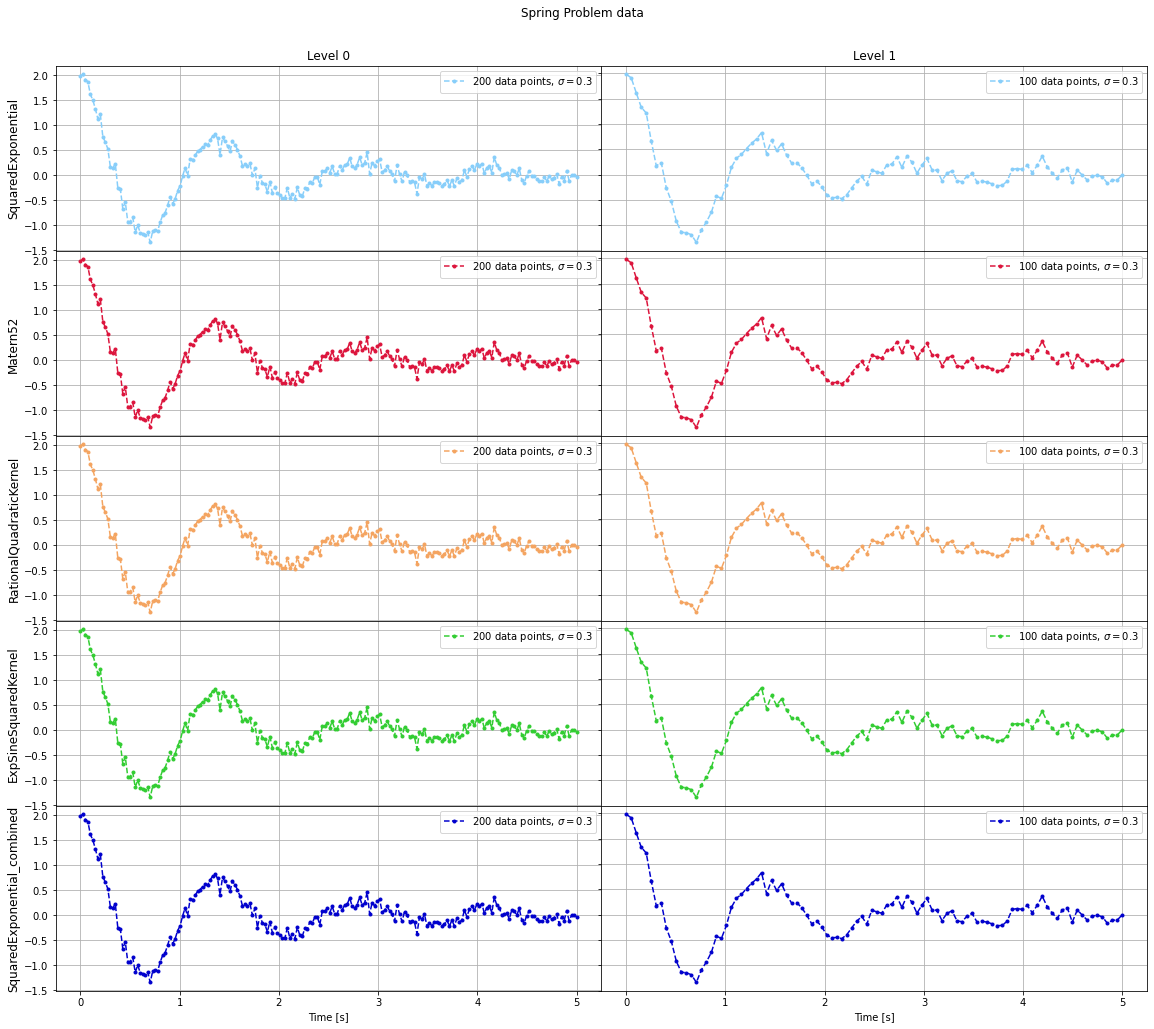

In [ ]:
datasets = []
method_names = get_all_kernel_names()

# Add noise
sigma = 0.3
u_noisy = u_true + np.random.normal(0, sigma ** 2, u_true.shape)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigma}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem data")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
method_names

['SquaredExponential',
 'Matern52',
 'RationalQuadraticKernel',
 'ExpSineSquaredKernel',
 'SquaredExponential_combined']

In [ ]:
# Set random process parameters.
mkl = 10 # Number of parameters in model

In [ ]:
t = np.linspace(0, T_max, u_true.shape[0])

random_process_list = [SquaredExponential(t, mkl, lamb = 0.5, var = 4.0), 
                       Matern52(t, mkl, lamb = 0.5, var = 4.0), 
                       RationalQuadraticKernel(t, mkl, lamb = 0.5, alpha = 0.1, var = 4.0),
                       ExpSineSquaredKernel(t, mkl, lamb = 0.5, p = 2, var = 4.0), 
                       SquaredExponential_combined(t, mkl, lamb = 2, p = 2, var = 4.0)]

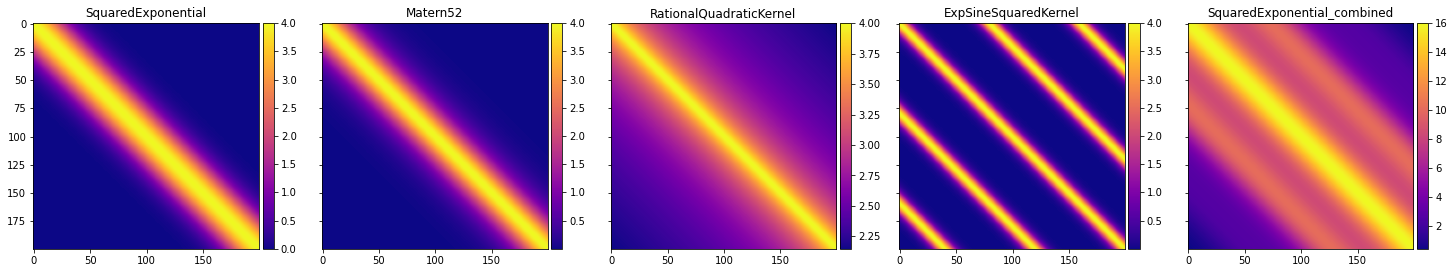

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

f,ax = plt.subplots(1,len(random_process_list), figsize=(25,5), sharey=True)
for i,process in enumerate(random_process_list):
  cov = process.cov
  # im = ax[i].imshow(cov, vmin = vmin, vmax=vmax, cmap='plasma')
  im = ax[i].imshow(cov, cmap='plasma')
  divider = make_axes_locatable(ax[i])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  f.colorbar(im, cax=cax, orientation='vertical')
  ax[i].set_title(method_names[i])
plt.show()
f.savefig(image_folder + "Kernel Priors.png",bbox_inches='tight',dpi=400)

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:

    # Generate covariance matrix
    t = np.linspace(0, T_max, data.shape[0])
    if i == 0:
      random_process = SquaredExponential(t, mkl, lamb = 0.5, var = 4.0)
    elif i == 1:
      random_process = Matern52(t, mkl, lamb = 0.5, var = 4.0)
    elif i == 2:
      random_process = RationalQuadraticKernel(t, mkl, lamb = 0.5, alpha = 0.1, var = 4.0)
    elif i == 3:
      random_process = ExpSineSquaredKernel(t, mkl, lamb = 0.5, p = 2, var = 4.0)
    elif i == 4:
      random_process = SquaredExponential_combined(t, mkl, lamb = 2, p = 2, var = 4.0)
    random_process.compute_eigenpairs()

    logl.append(LogLike(my_loglik, data, random_process, T_max, sigma = 1.0))
  logls.append(logl)

Create fine and coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros((mkl,))
cov_prior = np.eye(mkl)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
all_fine_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)
for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 3000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 2000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  with fine_model:
    if i == 0:
      MAP = pm.find_MAP()

    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          return_inferencedata=False,
          cores=10,
          start=MAP,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                        start=MAP,
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 64 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 59 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


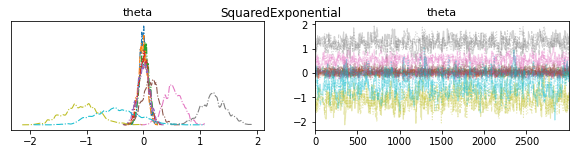

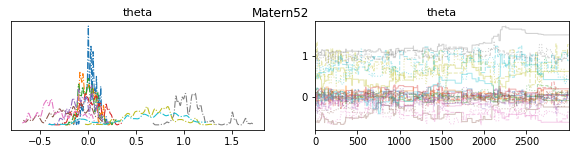

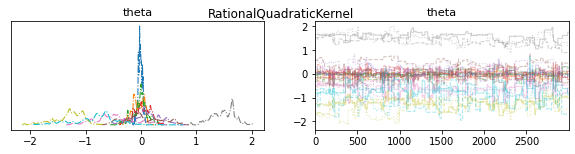

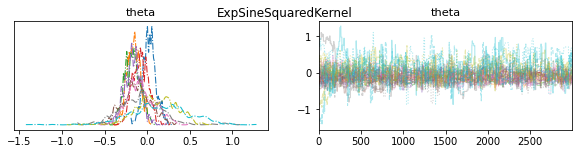

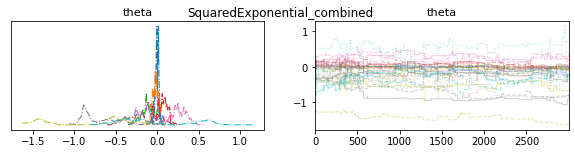

In [ ]:
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    f,ax = plt.subplots(1,2, figsize=(10,2))
    az.plot_trace(trace, axes = ax[None,:], compact = True, combined=True)
    f.suptitle(method_names[i])
    plt.show()

In [ ]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    # print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    # display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))

In [ ]:
# Model predictions
error = []
u_hats = []
for i,theta_hat in enumerate(theta_hats):
  u_hat = get_prediction(logls[i][0].random_process, theta_hat)
  mse = np.mean((u_true-u_hat)**2)
  u_hats.append(u_hat)
  error.append(mse)

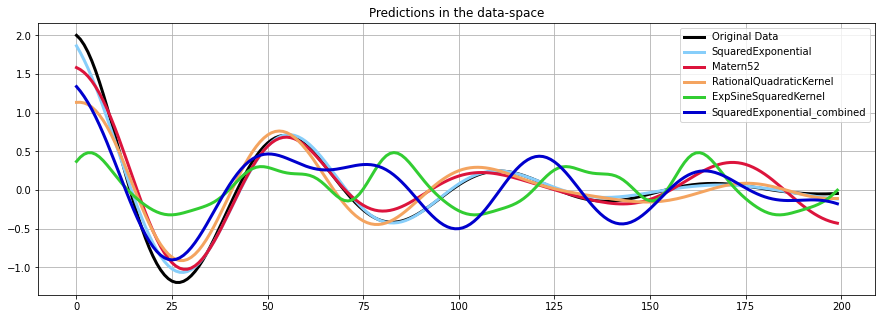

In [ ]:
f,ax = plt.subplots(figsize=(15,5))
ax.plot(u_true,'-k',lw=3,label="Original Data")
for i in range(len(all_traces)):
  ax.plot(u_hats[i],'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Predictions in the data-space")
plt.show()
f.savefig(image_folder + "predictions.png",bbox_inches='tight',dpi=300)

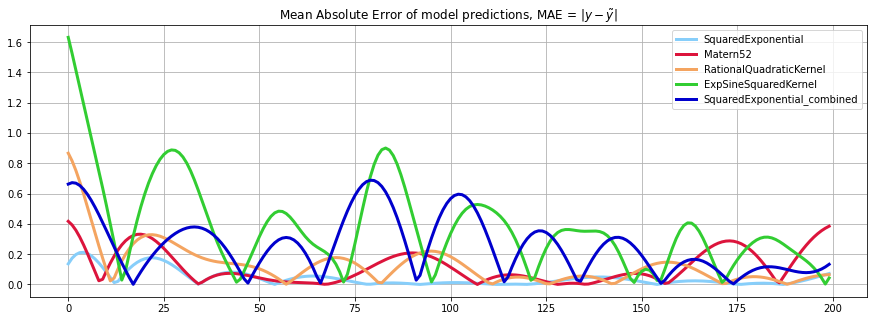

In [ ]:
f,ax = plt.subplots(figsize=(15,5))
for i in range(len(all_traces)):
  ax.plot(abs(u_true-u_hats[i]),'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Mean Absolute Error of model predictions, " + r"MAE = $|y-\tilde{y}|$")
plt.show()
f.savefig(image_folder + "MAE.png",bbox_inches='tight',dpi=300)

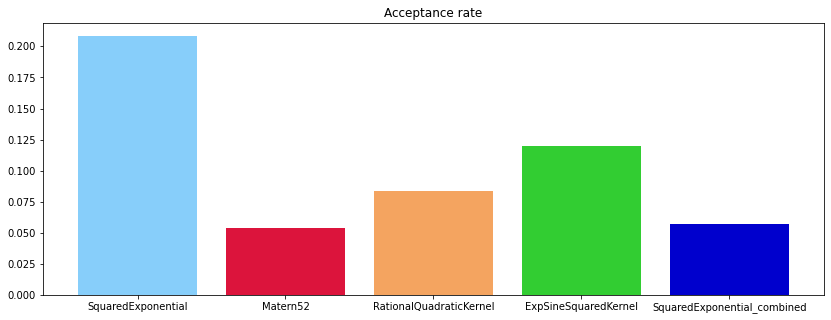

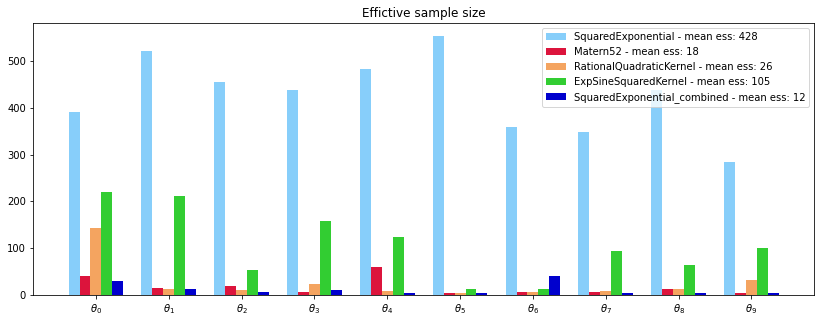

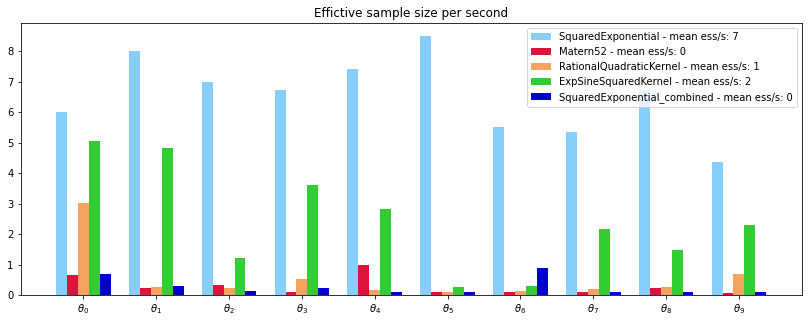

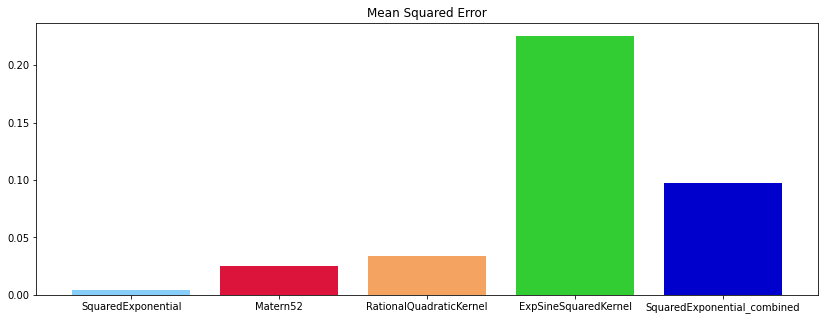

In [ ]:
# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)


f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size')
for i, e in enumerate(ess):
    ax.bar(
        [j + i * 0.15 for j in range(mkl)],
        e.ravel(),
        width=0.15,
        color=cols[i],
        label=method_names[i] + f" - mean ess: {round(np.mean(e))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size per second')
for i, p in enumerate(performances):
    ax.bar(
        [j + i * 0.15 for j in range(mkl)],
        p.ravel(),
        width=0.15,
        color=cols[i],
        label=method_names[i] + f" - mean ess/s: {round(np.mean(p))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Level Comparison

In [38]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "level_comparison_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 200
t = np.linspace(0, T_max, size)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

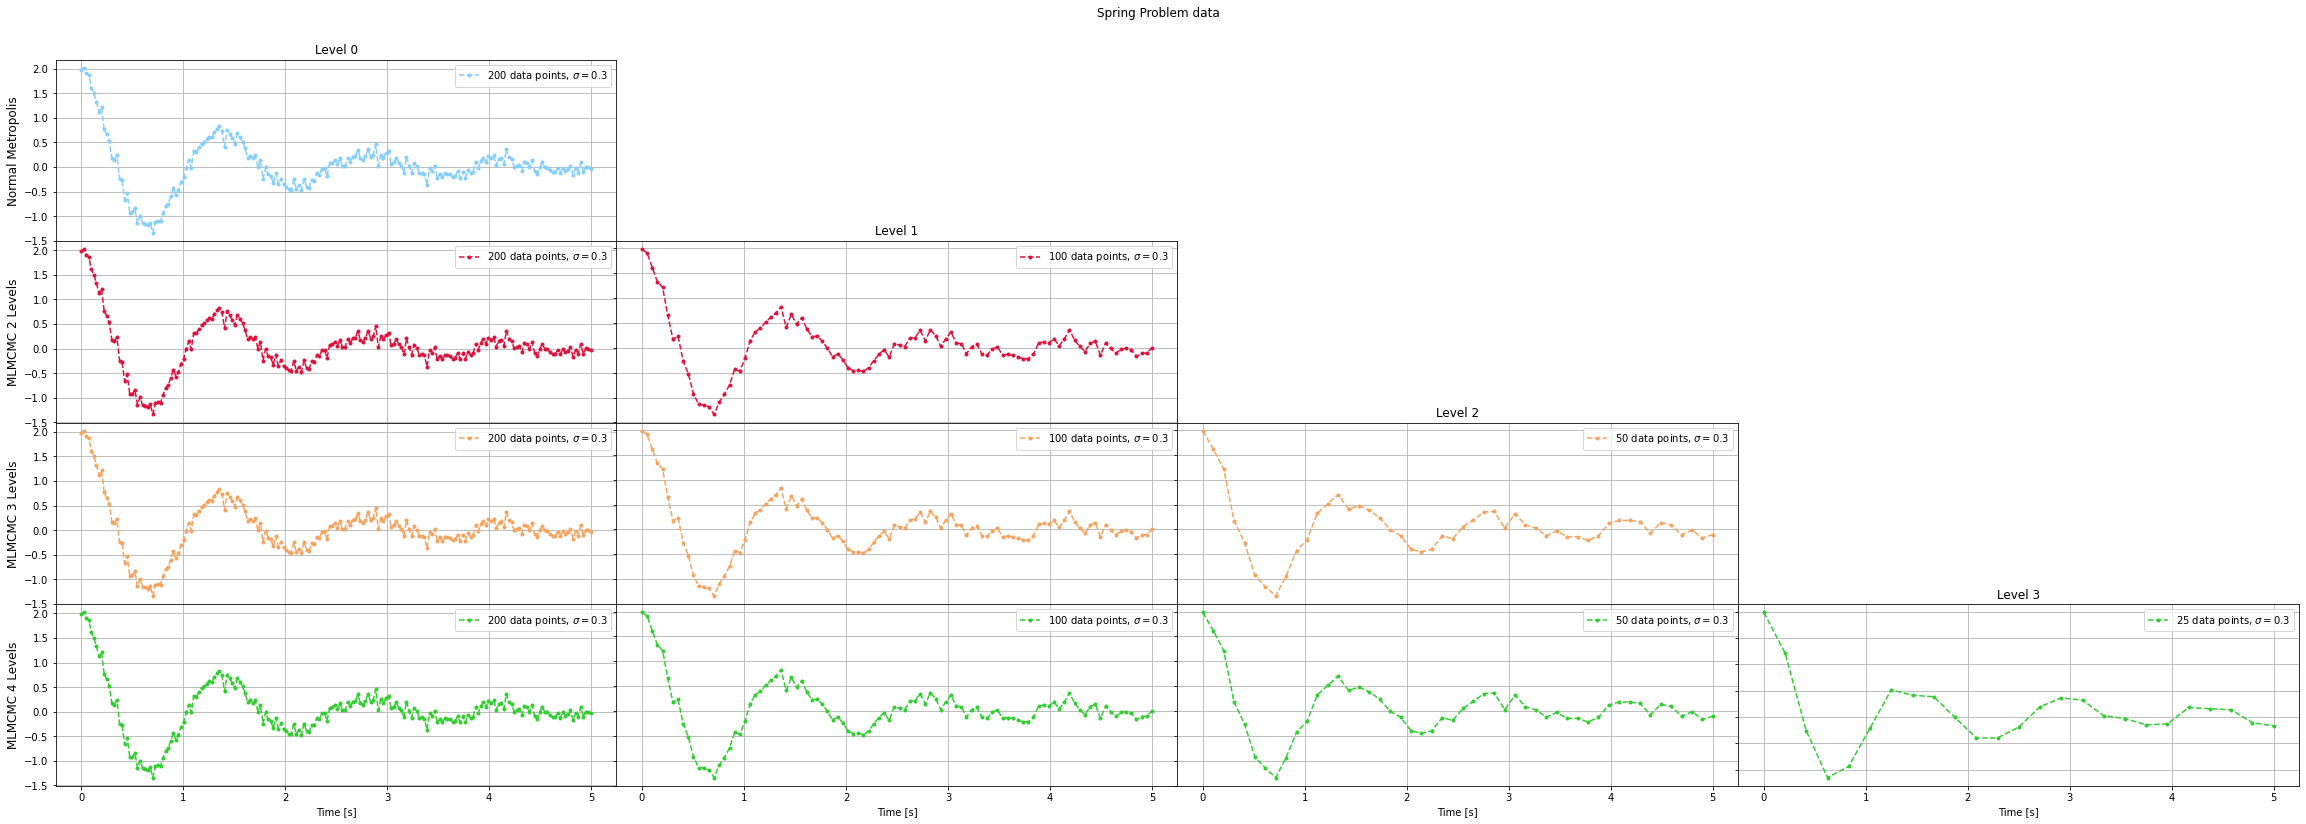

In [39]:
datasets = []
method_names = []

# Add noise
sigma = 0.3
u_noisy = u_true + np.random.normal(0, sigma ** 2, u_true.shape)

# New Dataset
dataset = []
dataset.append(u_noisy)
datasets.append(dataset)
method_names.append("Normal Metropolis")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("MLMCMC 2 Levels")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
dataset.append(u_noisy[::4])
datasets.append(dataset)
method_names.append("MLMCMC 3 Levels")

# New Dataset
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
dataset.append(u_noisy[::4])
dataset.append(u_noisy[::8])
datasets.append(dataset)
method_names.append("MLMCMC 4 Levels")


cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigma}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem data")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [40]:
# Set random process parameters.
mkl = 10 # Number of parameters in model
lamb = 0.5 # Lengthscale in covariance matrix
var = 4

In [41]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:

    # Generate covariance matrix
    t = np.linspace(0, T_max, data.shape[0])
    random_process = SquaredExponential(t, mkl, lamb, var)
    random_process.compute_eigenpairs()

    logl.append(LogLike(my_loglik, data, random_process, T_max, sigma = 1.0))
  logls.append(logl)

Create fine and coarse models

In [42]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros((mkl,))
cov_prior = np.eye(mkl)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
all_fine_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)
for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(mkl,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

[]
[<pymc3.model.Model object at 0x7f19ff79ab90>, <pymc3.model.Model object at 0x7f1a16d86690>]
[<pymc3.model.Model object at 0x7f1a16dbeb10>, <pymc3.model.Model object at 0x7f19ff10b5d0>, <pymc3.model.Model object at 0x7f1a16d7d5d0>]


Set MCMC parameters for inference

In [45]:
# Number of draws from the distribution
ndraws = 6000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 2000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [2, 3, 5]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [46]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  with fine_model:
    if i == 0:
      MAP = pm.find_MAP()

    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval,
                                      scaling = 0.1)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          return_inferencedata=False,
          cores=10,
          start=MAP,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)],
          base_scaling = 0.1,
          base_sampler = "Metropolis"
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                        start=MAP,
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

Multiprocess sampling (3 chains in 10 jobs)
Metropolis: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 22 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 88 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 263 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 2127 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


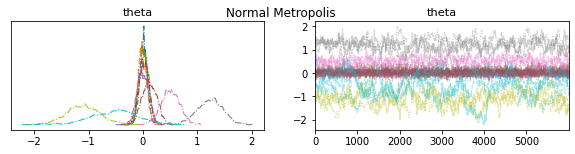

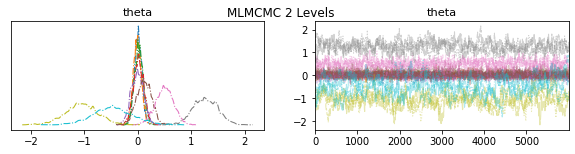

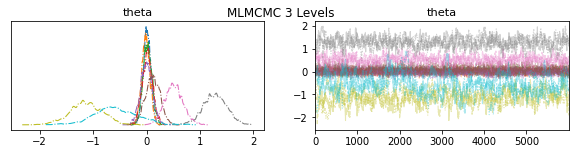

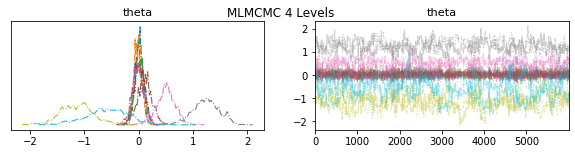

In [47]:
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    f,ax = plt.subplots(1,2, figsize=(10,2))
    az.plot_trace(trace, axes = ax[None,:], compact = True, combined=True)
    f.suptitle(method_names[i])
    plt.show()

In [48]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Normal Metropolis Sampler:
 runtime :  22.650586366653442


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.006  0.072  -0.134    0.133  ...    0.001    1311.0    2125.0   1.00
theta[1] -0.013  0.075  -0.143    0.135  ...    0.002    1135.0    1908.0   1.00
theta[2]  0.025  0.085  -0.137    0.180  ...    0.002     975.0    1659.0   1.00
theta[3]  0.012  0.095  -0.164    0.189  ...    0.002     820.0    1320.0   1.00
theta[4] -0.001  0.112  -0.206    0.204  ...    0.003     565.0    1087.0   1.01
theta[5]  0.117  0.140  -0.132    0.379  ...    0.004     541.0    1129.0   1.00
theta[6]  0.502  0.175   0.178    0.838  ...    0.007     325.0     343.0   1.01
theta[7]  1.235  0.240   0.769    1.667  ...    0.021      73.0     204.0   1.04
theta[8] -1.103  0.317  -1.667   -0.452  ...    0.042      29.0     193.0   1.11
theta[9] -0.535  0.460  -1.342    0.388  ...    0.050      44.0      57.0   1.06

[10 rows x 9 columns]


MLMCMC 2 Levels Sampler:
 runtime :  89.23808312416077


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.007  0.070  -0.124    0.140  ...    0.001    2033.0    2661.0   1.00
theta[1] -0.010  0.074  -0.137    0.139  ...    0.001    1729.0    2691.0   1.00
theta[2]  0.020  0.081  -0.128    0.175  ...    0.001    1525.0    2282.0   1.00
theta[3]  0.015  0.098  -0.165    0.196  ...    0.002    1227.0    1955.0   1.00
theta[4] -0.008  0.118  -0.217    0.220  ...    0.003     944.0    1469.0   1.00
theta[5]  0.115  0.139  -0.137    0.365  ...    0.004     761.0    1244.0   1.00
theta[6]  0.501  0.170   0.196    0.831  ...    0.005     537.0     969.0   1.00
theta[7]  1.266  0.232   0.818    1.679  ...    0.010     306.0     510.0   1.01
theta[8] -1.056  0.310  -1.638   -0.473  ...    0.016     194.0     394.0   1.01
theta[9] -0.465  0.374  -1.157    0.247  ...    0.034      64.0     186.0   1.05

[10 rows x 9 columns]


MLMCMC 3 Levels Sampler:
 runtime :  264.79262590408325


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.007  0.070  -0.119    0.142  ...    0.001    2145.0    2797.0   1.00
theta[1] -0.013  0.077  -0.160    0.126  ...    0.001    1972.0    2748.0   1.00
theta[2]  0.019  0.084  -0.134    0.177  ...    0.002    1551.0    2278.0   1.00
theta[3]  0.016  0.097  -0.169    0.194  ...    0.002    1352.0    2065.0   1.00
theta[4] -0.003  0.112  -0.217    0.206  ...    0.002    1234.0    1862.0   1.00
theta[5]  0.114  0.139  -0.156    0.363  ...    0.004     637.0    1014.0   1.00
theta[6]  0.510  0.170   0.191    0.833  ...    0.006     392.0     547.0   1.01
theta[7]  1.281  0.223   0.889    1.733  ...    0.008     368.0     648.0   1.01
theta[8] -1.132  0.310  -1.756   -0.593  ...    0.015     224.0     450.0   1.01
theta[9] -0.571  0.416  -1.330    0.218  ...    0.028     114.0     185.0   1.04

[10 rows x 9 columns]


MLMCMC 4 Levels Sampler:
 runtime :  2127.987711429596


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]  0.009  0.071  -0.132    0.127  ...    0.002     923.0    1454.0   1.00
theta[1] -0.012  0.076  -0.152    0.132  ...    0.002    1056.0    1166.0   1.00
theta[2]  0.021  0.086  -0.135    0.192  ...    0.002     845.0    1178.0   1.00
theta[3]  0.012  0.099  -0.163    0.199  ...    0.003     769.0    1314.0   1.00
theta[4] -0.013  0.111  -0.202    0.214  ...    0.003     876.0    1137.0   1.00
theta[5]  0.108  0.140  -0.180    0.347  ...    0.004     596.0     522.0   1.01
theta[6]  0.503  0.180   0.168    0.840  ...    0.007     298.0     423.0   1.01
theta[7]  1.247  0.244   0.823    1.727  ...    0.014     145.0     324.0   1.01
theta[8] -1.135  0.306  -1.685   -0.537  ...    0.018     145.0     215.0   1.02
theta[9] -0.562  0.400  -1.421    0.098  ...    0.030     104.0     128.0   1.02

[10 rows x 9 columns]

In [49]:
# Model predictions
error = []
u_hats = []
for i,theta_hat in enumerate(theta_hats):
  u_hat = get_prediction(logls[i][0].random_process, theta_hat)
  mse = np.mean((u_true-u_hat)**2)
  u_hats.append(u_hat)
  error.append(mse)

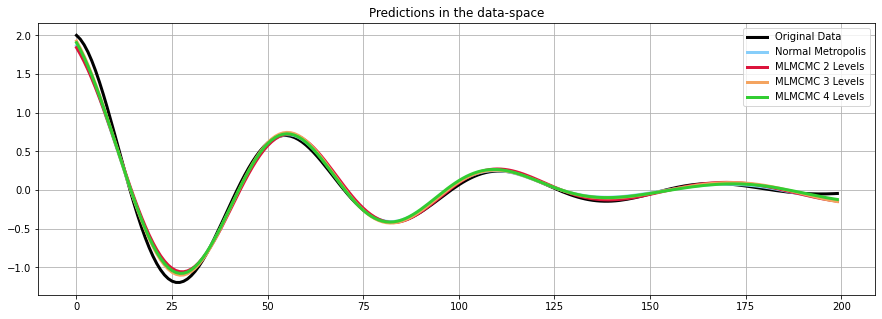

In [50]:
f,ax = plt.subplots(figsize=(15,5))
ax.plot(u_true,'-k',lw=3,label="Original Data")
for i in range(len(all_traces)):
  ax.plot(u_hats[i],'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Predictions in the data-space")
plt.show()
f.savefig(image_folder + "predictions.png",bbox_inches='tight',dpi=300)

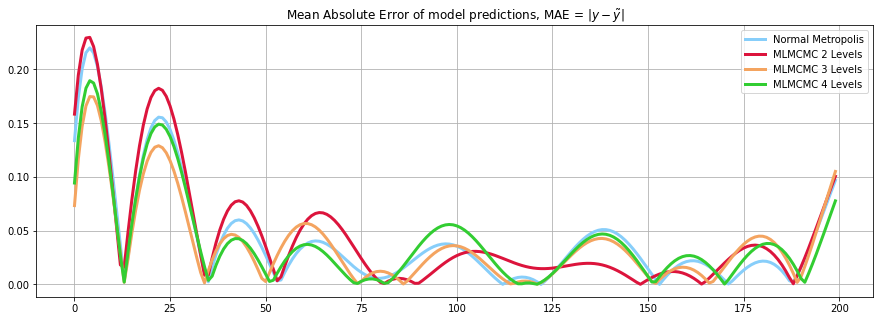

In [51]:
f,ax = plt.subplots(figsize=(15,5))
for i in range(len(all_traces)):
  ax.plot(abs(u_true-u_hats[i]),'-', lw=3, color=cols[i], label=method_names[i])
ax.legend()
ax.grid('on')
ax.set_title("Mean Absolute Error of model predictions, " + r"MAE = $|y-\tilde{y}|$")
plt.show()
f.savefig(image_folder + "MAE.png",bbox_inches='tight',dpi=300)

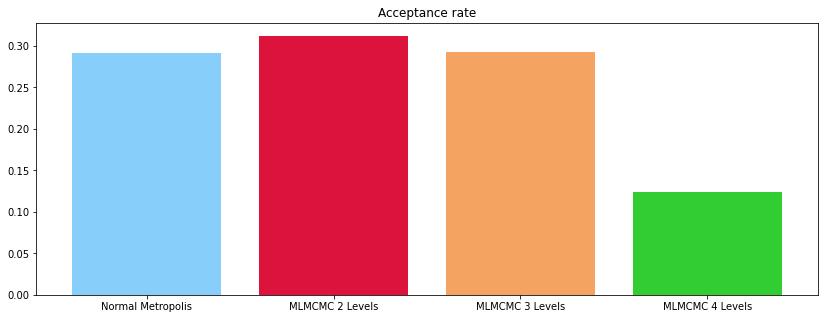

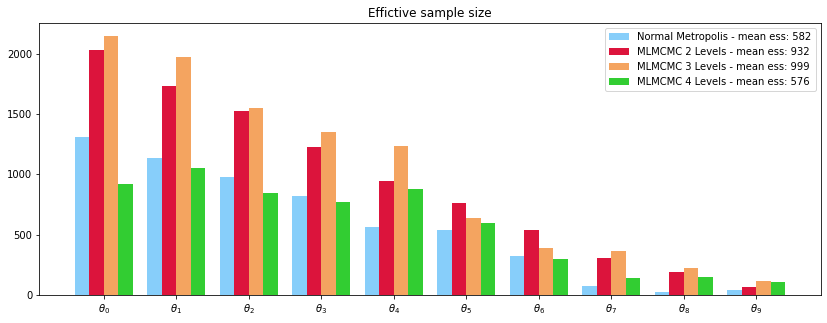

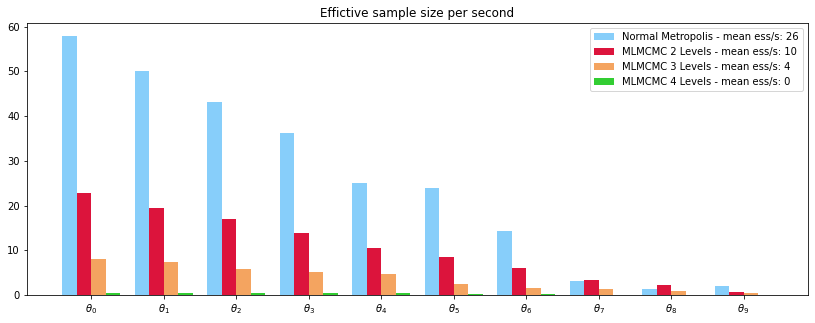

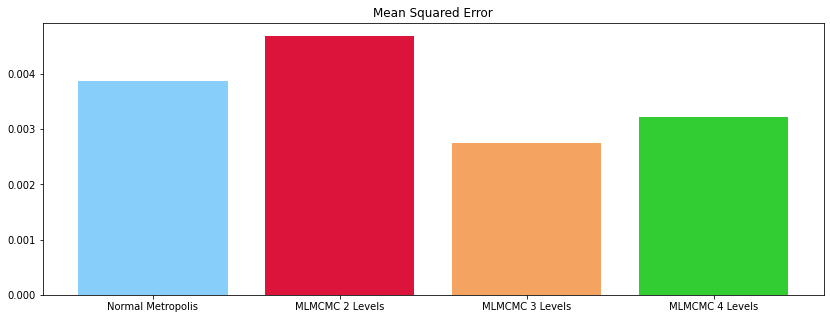

In [52]:
# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)


f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size')
for i, e in enumerate(ess):
    ax.bar(
        [j + i * 0.2 for j in range(mkl)],
        e.ravel(),
        width=0.2,
        color=cols[i],
        label=method_names[i] + f" - mean ess: {round(np.mean(e))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size per second')
for i, p in enumerate(performances):
    ax.bar(
        [j + i * 0.2 for j in range(mkl)],
        p.ravel(),
        width=0.2,
        color=cols[i],
        label=method_names[i] + f" - mean ess/s: {round(np.mean(p))}",
    )
ax.set_xticks([i + 0.3 for i in range(mkl)])
ax.set_xticklabels([rf"$\theta_{{{i}}}$" for i in range(mkl)])
ax.legend()
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Download figures

In [53]:
!zip -r spring_problem_numerical.zip spring_problem_numerical/ &> /dev/null

In [54]:
from google.colab import files
files.download("spring_problem_numerical.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>